## Problem 3

In this problem, we explore the flow in a frictionless converging-diverging circular duct.  We will now consider the utility of second-order advection schemes to explore errors associated with UDS.  Implement the CDS and QUICK schemes into the momentum equation.  You can essentially use what you created in the previous assignment for this task.

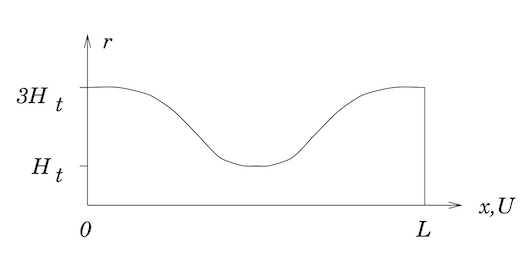

The duct is defined by:
$$
    r=2H_t + H_t cos \left( 2\pi \frac{x}{L} \right)
$$

where $L=1$ [m], $H_t=0.01$ [m].  You will have to modify the `Grid` class in order to solve this problem. Keep the general structure of the class, but modify the calculation of the areas and volumes appropriately. The inlet velocity should be imposed as $u=2$ [m/s].  To eliminate friction in the duct, be sure to turn off the wall friction terms from the previous problem.  Solve the problem using 8, 16, 32 and 64 equal-length control-volumes and calculate the loss in dynamic head from each converged solution.  The dynamic head loss is given as:

$$
    C_D= \frac{P_{in} - P_{out}}{\frac{1}{2} \rho U_{in}^2}
$$

Compare your solutions from UDS with those from the second-order schemes and quantify the convergence characteristics of each.  Plot the velocities and pressures versus $x$ for enough of the cases to visualize the results properly.  What should $C_D$ become for this problem?

# Class definition

In [420]:
import numpy as np

class Grid:
    """Class defining a one-dimensional Cartesian grid"""

    def __init__(self, lx, Ht, ncv):
        """Constructor
            lx .... total length of domain in x-direction [m]
            Ht .... total length of domain in y-direction [m]
            ncv ... number of control volumes in domain
        """
        # Store the number of control volumes
        self._ncv = ncv

        # Calculate the control volume length
        dx = lx/float(ncv)

        # Calculate the face locations
        self._xf = np.array([i*dx for i in range(ncv+1)])

        # Calculate the cell centroid locations
        self._xP = np.array([self._xf[0]] +
                            [0.5*(self._xf[i]+self._xf[i+1]) for i in range(ncv)] +
                            [self._xf[-1]])
        
        # Calculate the radius of the channel at face locations
        self._rf = (2*Ht) + (Ht*np.cos((2*np.pi*self._xf)/lx))
        
        # Calculate the radius of the channel at cell centroid locations
        self._rP = (2*Ht) + (Ht*np.cos((2*np.pi*self._xP)/lx))
        
        # Calculate face areas
        self._Af = np.pi * ((self._rf)**2)

        # Calculate the outer surface area for each cell
        self._Ao = (2*np.pi*self._rP[1:-1])*dx

        # Calculate cell volumes
        self._vol = np.pi*(self._rP[1:-1]**2)*dx
        
    @property
    def ncv(self):
        """Number of control volumes in domain"""
        return self._ncv

    @property
    def xf(self):
        """Face location array"""
        return self._xf

    @property
    def xP(self):
        """Cell centroid array"""
        return self._xP
    
    @property
    def rf(self):
        """Radius at Face location array"""
        return self._rf
    
    @property
    def rP(self):
        """Radius at Cell centroid array"""
        return self._rP

    @property
    def dx_WP(self):
        return self.xP[1:-1]-self.xP[0:-2]

    @property
    def dx_PE(self):
        return self.xP[2:]-self.xP[1:-1]

    @property
    def Af(self):
        """Face area array"""
        return self._Af

    @property
    def Aw(self):
        """West face area array"""
        return self._Af[0:-1]

    @property
    def Ae(self):
        """East face area array"""
        return self._Af[1:]

    @property
    def Ao(self):
        """Outer face area array"""
        return self._Ao

    @property
    def vol(self):
        """Cell volume array"""
        return self._vol


In [421]:
import numpy as np

class ScalarCoeffs:
    """Class defining the set of coefficients for a finite-volume discretization
       of a scalar partial differential equation.
    """

    def __init__(self, ncv):
        """Constructor
            ncv ... number of control volumes in domain
        """
        self._ncv = ncv
        self._aP = np.zeros(ncv)
        self._aW = np.zeros(ncv)
        self._aE = np.zeros(ncv)
        self._rP = np.zeros(ncv)

    def zero(self):
        """Function to zero the coefficient arrays"""
        self._aP.fill(0.0)
        self._aW.fill(0.0)
        self._aE.fill(0.0)
        self._rP.fill(0.0)

    def accumulate_aP(self, aP):
        """Function to accumulate values onto aP"""
        self._aP += aP

    def accumulate_aW(self, aW):
        """Function to accumulate values onto aW"""
        self._aW += aW

    def accumulate_aE(self, aE):
        """Function to accumulate values onto aE"""
        self._aE += aE

    def accumulate_rP(self, rP):
        """Function to accumulate values onto rP"""
        self._rP += rP

    @property
    def ncv(self):
        """Number of control volumes in domain"""
        return self._ncv

    @property
    def aP(self):
        """Cell coefficient"""
        return self._aP

    @property
    def aW(self):
        """West cell coefficient"""
        return self._aW

    @property
    def aE(self):
        """East cell coefficient"""
        return self._aE

    @property
    def rP(self):
        """Cell residual"""
        return self._rP

In [422]:
from enum import Enum

class BoundaryLocation(Enum):
    """Enumeration class defining boundary condition locations"""
    WEST = 1
    EAST = 2

class DirichletBc:
    """Class defining a Dirichlet boundary condition"""

    def __init__(self, phi, grid, value, loc):
        """Constructor
            phi ..... field variable array
            grid .... grid
            value ... boundary value
            loc ..... boundary location
        """
        self._phi = phi
        self._grid = grid
        self._value = value
        self._loc = loc

    def value(self):
        """Return the boundary condition value"""
        return self._value

    def coeff(self):
        """Return the linearization coefficient"""
        return 0

    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            self._phi[0] = self._value
        elif self._loc is BoundaryLocation.EAST:
            self._phi[-1] = self._value
        else:
            raise ValueError("Unknown boundary location")

class NeumannBc:
    """Class defining a Neumann boundary condition"""

    def __init__(self, phi, grid, gradient, loc):
        """Constructor
            phi ........ field variable array
            grid ....... grid
            gradient ... gradient at cell adjacent to boundary
            loc ........ boundary location
        """
        self._phi = phi
        self._grid = grid
        self._gradient = gradient
        self._loc = loc

    def value(self):
        """Return the boundary condition value"""
        if self._loc is BoundaryLocation.WEST:
            return self._phi[1] - self._gradient*self._grid.dx_WP[0]
        elif self._loc is BoundaryLocation.EAST:
            return self._phi[-2] + self._gradient*self._grid.dx_PE[-1]
        else:
            raise ValueError("Unknown boundary location")

    def coeff(self):
        """Return the linearization coefficient"""
        return 1

    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            self._phi[0] = self._phi[1] - self._gradient*self._grid.dx_WP[0]
        elif self._loc is BoundaryLocation.EAST:
            self._phi[-1] = self._phi[-2] + self._gradient*self._grid.dx_PE[-1]
        else:
            raise ValueError("Unknown boundary location")

In [423]:
class DiffusionModel:
    """Class defining a diffusion model"""

    def __init__(self, grid, phi, gamma, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._gamma = gamma
        self._west_bc = west_bc
        self._east_bc = east_bc

    def add(self, coeffs):
        """Function to add diffusion terms to coefficient arrays"""

        # Calculate the west and east face diffusion flux terms for each face
        flux_w = - self._gamma*self._grid.Aw*(self._phi[1:-1]-self._phi[0:-2])/self._grid.dx_WP
        flux_e = - self._gamma*self._grid.Ae*(self._phi[2:]-self._phi[1:-1])/self._grid.dx_PE

        # Calculate the linearization coefficients
        coeffW = - self._gamma*self._grid.Aw/self._grid.dx_WP
        coeffE = - self._gamma*self._grid.Ae/self._grid.dx_PE
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)

        # Return the modified coefficient array
        return coeffs

import numpy

class FirstOrderTransientModel:
    """Class defining a first order implicit transient model"""

    def __init__(self, grid, phi, phiold, rho, const, dt):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._phiold = phiold
        self._rho = rho
        self._const = const
        self._dt = dt

    def add(self, coeffs):
        """Function to add transient term to coefficient arrays"""

        # Calculate the transient term
        transient = self._rho*self._const*self._grid.vol*(self._phi[1:-1]-self._phiold[1:-1])/self._dt

        # Calculate the linearization coefficient
        coeff = self._rho*self._const*self._grid.vol/self._dt

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeff)
        coeffs.accumulate_rP(transient)

        return coeffs


In [424]:
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix

def get_sparse_matrix(PP_coeffs, PU_coeffs, UP_coeffs, UU_coeffs):
    """Function to return a sparse matrix representation of a set of scalar coefficients"""

    # Get number of control volumes (check that all are consistent)
    ncv = PP_coeffs.ncv
    if ncv is not PU_coeffs.ncv or ncv is not UP_coeffs.ncv or ncv is not UU_coeffs.ncv:
        raise ValueError("Not all coefficient arrays have the same dimension")

    # Set up the data and indexing arrays
    nvar = 2  # P, U
    ncoeff = 3  # aW, aP, and aE
    ndata = nvar*nvar*ncoeff*ncv - 2*nvar*nvar # Need to subtract boundary coefficients
    data = np.zeros(ndata)
    rows = np.zeros(ndata, dtype=int)
    cols = np.zeros(ndata, dtype=int)

    # Set up the first cell
    data[0] = PP_coeffs.aP[0]
    cols[0] = 0
    data[1] = PU_coeffs.aP[0]
    cols[1] = 1
    data[2] = PP_coeffs.aE[0]
    cols[2] = 2
    data[3] = PU_coeffs.aE[0]
    cols[3] = 3
    data[4] = UP_coeffs.aP[0]
    cols[4] = 0
    data[5] = UU_coeffs.aP[0]
    cols[5] = 1
    data[6] = UP_coeffs.aE[0]
    cols[6] = 2
    data[7] = UU_coeffs.aE[0]
    cols[7] = 3

    rows[0:4] = 0
    rows[4:8] = 1

    # Set up the interior cells
    for i in range(1, ncv-1):
        start = nvar*nvar*ncoeff*(i-1) + 8
        data[start+0] = PP_coeffs.aW[i]
        cols[start+0] = nvar*i - 2
        data[start+1] = PU_coeffs.aW[i]
        cols[start+1] = nvar*i - 1
        data[start+2] = PP_coeffs.aP[i]
        cols[start+2] = nvar*i
        data[start+3] = PU_coeffs.aP[i]
        cols[start+3] = nvar*i + 1
        data[start+4] = PP_coeffs.aE[i]
        cols[start+4] = nvar*i + 2
        data[start+5] = PU_coeffs.aE[i]
        cols[start+5] = nvar*i + 3
        data[start+6] = UP_coeffs.aW[i]
        cols[start+6] = nvar*i - 2
        data[start+7] = UU_coeffs.aW[i]
        cols[start+7] = nvar*i - 1
        data[start+8] = UP_coeffs.aP[i]
        cols[start+8] = nvar*i
        data[start+9] = UU_coeffs.aP[i]
        cols[start+9] = nvar*i + 1
        data[start+10] = UP_coeffs.aE[i]
        cols[start+10] = nvar*i + 2
        data[start+11] = UU_coeffs.aE[i]
        cols[start+11] = nvar*i + 3

        rows[start:start+6] = nvar*i
        rows[start+6:start+12] = nvar*i + 1

    # Set up the last cell
    i = ncv - 1
    start = nvar*nvar*ncoeff*(i-1) + 8
    data[start+0] = PP_coeffs.aW[i]
    cols[start+0] = nvar*i - 2
    data[start+1] = PU_coeffs.aW[i]
    cols[start+1] = nvar*i - 1
    data[start+2] = PP_coeffs.aP[i]
    cols[start+2] = nvar*i
    data[start+3] = PU_coeffs.aP[i]
    cols[start+3] = nvar*i + 1
    data[start+4] = UP_coeffs.aW[i]
    cols[start+4] = nvar*i - 2
    data[start+5] = UU_coeffs.aW[i]
    cols[start+5] = nvar*i - 1
    data[start+6] = UP_coeffs.aP[i]
    cols[start+6] = nvar*i
    data[start+7] = UU_coeffs.aP[i]
    cols[start+7] = nvar*i + 1

    rows[start:start+4] = nvar*i
    rows[start+4:start+8] = nvar*i + 1

    # Return the matrix
    return csr_matrix((data, (rows, cols)))

def solve(PP_coeffs, PU_coeffs, UP_coeffs, UU_coeffs):
    """Function to solve the linear system and return the correction fields"""

    # Get number of control volumes (check that all are consistent)
    ncv = PP_coeffs.ncv
    if ncv is not PU_coeffs.ncv or ncv is not UP_coeffs.ncv or ncv is not UU_coeffs.ncv:
        raise ValueError("Not all coefficient arrays have the same dimension")

    # Get the sparse matrix
    A = get_sparse_matrix(PP_coeffs, PU_coeffs, UP_coeffs, UU_coeffs)

    # Create and fill the right side vector
    b = np.zeros(2*ncv)
    for i in range(ncv):
        b[2*i] = - PP_coeffs.rP[i] - PU_coeffs.rP[i]
        b[2*i+1] = - UP_coeffs.rP[i] - UU_coeffs.rP[i]

    # Solve the linear system
    res = spsolve(A,b)

    # Extract the correction fields
    dP = np.zeros(ncv)
    dU = np.zeros(ncv)
    for i in range(ncv):
        dP[i] = res[2*i]
        dU[i] = res[2*i+1]

    return dP, dU


In [425]:
class UpwindAdvectionModel:
    """Class defining an upwind advection model"""

    def __init__(self, grid, phi, Uhe, rho, const, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._Uhe = Uhe
        self._rho = rho
        self._const = const
        self._west_bc = west_bc
        self._east_bc = east_bc
        self._alphae = np.zeros(self._grid.ncv+1)
        self._phie = np.zeros(self._grid.ncv+1)

    def add(self, coeffs):
        """Function to add diffusion terms to coefficient arrays"""

        # Calculate the weighting factors
        for i in range(self._grid.ncv+1):
            if self._Uhe[i] >= 0:
                self._alphae[i] = 1
            else:
                self._alphae[i] = -1           
        
        # Calculate the east integration point values (including both boundaries)
        self._phie = (1 + self._alphae)/2*self._phi[0:-1] + (1 - self._alphae)/2*self._phi[1:]
        
        # Calculate the face mass fluxes
        mdote = self._rho*self._Uhe*self._grid.Af
        
        # Calculate the west and east face advection flux terms for each face
        flux_w = self._const*mdote[:-1]*self._phie[:-1]
        flux_e = self._const*mdote[1:]*self._phie[1:]
        
        # Calculate mass imbalance term
        imbalance = - self._const*mdote[1:]*self._phi[1:-1] + self._const*mdote[:-1]*self._phi[1:-1]
          
        # Calculate the linearization coefficients
        coeffW = - self._const*mdote[:-1]*(1 + self._alphae[:-1])/2
        coeffE = self._const*mdote[1:]*(1 - self._alphae[1:])/2
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        coeffs.accumulate_rP(imbalance)

        # Return the modified coefficient array
        return coeffs

In [426]:
class CentralDifferenceModel:
    """Class defining a Central difference advection model with Deffered correction approach"""

    def __init__(self, grid, phi, Uhe, rho, cp, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._Uhe = Uhe
        self._rho = rho
        self._cp = cp
        self._west_bc = west_bc
        self._east_bc = east_bc
        self._alphae = np.zeros(self._grid.ncv+1)
        self._phie = np.zeros(self._grid.ncv+1)
        self._phie_UDS = np.zeros(self._grid.ncv+1)
 
    def add(self, coeffs):
        """Function to add advention terms to coefficient arrays"""

        # Calculate the weighting factors
        for i in range(self._grid.ncv+1):
            if self._Uhe[i] >= 0:
                self._alphae[i] = 1
                #self._alphae [-1] = -1
            else:
                self._alphae[i] = -1
                #self._alphae[0] = 1
        
        # Calculate the east integration point values (including both boundaries)
        self._phie = (self._phi[0:-1] + self._phi[1:])/2 # Using HOS
        self._phie_UDS = (1 + self._alphae)/2*self._phi[0:-1] + (1 - self._alphae)/2*self._phi[1:] # For modification of boundary values
        self._phie[0] = self._phie_UDS[0]
        self._phie[-1] = self._phie_UDS[-1]
        
        # Calculate the face mass fluxes
        mdote = self._rho*self._Uhe*self._grid.Af
        
        # Calculate the west and east face advection flux terms for each face      
        flux_w = self._cp*mdote[:-1]*self._phie[:-1]
        flux_e = self._cp*mdote[1:]*self._phie[1:]
                
        # Calculate mass imbalance term
        imbalance = - self._cp*mdote[1:]*self._phi[1:-1] + self._cp*mdote[:-1]*self._phi[1:-1]
          
        # Calculate the linearization coefficients
        coeffW = - self._cp*mdote[:-1]*(1 + self._alphae[:-1])/2
        coeffE = self._cp*mdote[1:]*(1 - self._alphae[1:])/2
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w 

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        coeffs.accumulate_rP(imbalance)
 
        # Return the modified coefficient array
        return coeffs

In [427]:
import numpy as np

class QuickAdvectionModel:
    """Class defining an upwind advection model"""

    def __init__(self, grid, phi, Uhe, rho, cp, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._Uhe = Uhe
        self._rho = rho
        self._cp = cp
        self._west_bc = west_bc
        self._east_bc = east_bc
        self._alphae = np.zeros(self._grid.ncv+1)
        self._phie = np.zeros(self._grid.ncv+1)
        self._phie_UDS = np.zeros(self._grid.ncv+1)
    def add(self, coeffs):
        """Function to add diffusion terms to coefficient arrays"""

        # Calculate the weighting factors
        for i in range(self._grid.ncv+1):
            if self._Uhe[i] >= 0:
                self._alphae[i] = 1
                #self._alphae[-1] = -1
            else:
                self._alphae[i] = -1
                #self._alphae[0] = 1
        
        # Calculate the east integration point values (including both boundaries)
        self._phie_UDS = (1 + self._alphae)/2*self._phi[0:-1] + (1- self._alphae)/2*self._phi[1:]
        self._phie[0] = self._phie_UDS[0]
        self._phie[-1] = self._phie_UDS[-1]
        
        for i in range(1,self._grid.ncv):
                if self._Uhe[i] >=0:
                    T_1 = ((self._grid.xf[i] - self._grid.xP[i])*(self._grid.xf[i] - self._grid.xP[i+1])/((self._grid.xP[i-1] - self._grid.xP[i])*(self._grid.xP[i-1] - self._grid.xP[i+1])))*self._phi[i-1]  
                    T_2 = ((self._grid.xf[i] - self._grid.xP[i-1])*(self._grid.xf[i] - self._grid.xP[i+1])/((self._grid.xP[i] - self._grid.xP[i-1])*(self._grid.xP[i] - self._grid.xP[i+1])))*self._phi[i]  
                    T_3 = ((self._grid.xf[i] - self._grid.xP[i-1])*(self._grid.xf[i] - self._grid.xP[i])/((self._grid.xP[i+1] - self._grid.xP[i-1])*(self._grid.xP[i+1] - self._grid.xP[i])))*self._phi[i+1]
                    self._phie[i] = T_1 + T_2 + T_3
        
                else:
                    T_1 = ((self._grid.xf[i] - self._grid.xP[i+1])*(self._grid.xf[i] - self._grid.xP[i+2])/((self._grid.xP[i] - self._grid.xP[i+1])*(self._grid.xP[i] - self._grid.xP[i+2])))*self._phi[i]  
                    T_2 = ((self._grid.xf[i] - self._grid.xP[i])*(self._grid.xf[i] - self._grid.xP[i+2])/((self._grid.xP[i+1] - self._grid.xP[i])*(self._grid.xP[i+1] - self._grid.xP[i+2])))*self._phi[i+1]  
                    T_3 =((self._grid.xf[i] - self._grid.xP[i])*(self._grid.xf[i] - self._grid.xP[i+1])/((self._grid.xP[i+2] - self._grid.xP[i])*(self._grid.xP[i+2] - self._grid.xP[i+1])))*self._phi[i+2]                
                    self._phie[i] = T_1 + T_2 + T_3
   
        # Calculate the face mass fluxes
        mdote = self._rho*self._Uhe*self._grid.Af
        
        # Calculate the west and east face advection flux terms for each face
        flux_w = self._cp*mdote[:-1]*self._phie[:-1]
        flux_e = self._cp*mdote[1:]*self._phie[1:]
        
        # Calculate mass imbalance term
        imbalance = - self._cp*mdote[1:]*self._phi[1:-1] + self._cp*mdote[:-1]*self._phi[1:-1]
          
        # Calculate the linearization coefficients
        coeffW = - self._cp*mdote[:-1]*(1 + self._alphae[:-1])/2
        coeffE = self._cp*mdote[1:]*(1 - self._alphae[1:])/2
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        coeffs.accumulate_rP(imbalance)

        # Return the modified coefficient array
        return coeffs


In [428]:
class AdvectingVelocityModel:
    """Class defining an advecting velocity model"""

    def __init__(self, grid, dhat, Uhe, P, U, coeffs):
        """Constructor"""
        self._grid = grid
        self._dhat = dhat
        self._Uhe = Uhe
        self._P = P
        self._U = U
        self._coeffs = coeffs

    def update(self):
        """Function to update the advecting velocity array"""

        # Calculate the pressure gradients across the faces
        gradPw = (self._P[1:-1]-self._P[0:-2])/self._grid.dx_WP
        gradPe = (self._P[2:]-self._P[1:-1])/self._grid.dx_PE
        
        # Calculate the cell pressure gradients
        gradP = 0.5*(gradPw + gradPe)
          
        # Calculate damping coefficient, dhat
        Ve = 0.5*(self._grid.vol[0:-1] + self._grid.vol[1:])
        ae = 0.5*(self._coeffs.aP[0:-1] + self._coeffs.aP[1:])
        self._dhat[1:-1] = Ve/ae

        # Update the advecting velocity
        self._Uhe[0] = self._U[0]
        self._Uhe[1:-1] = 0.5*(self._U[1:-2] + self._U[2:-1]) - self._dhat[1:-1]*(gradPe[:-1] - 0.5*(gradP[:-1] + gradP[1:]))
        self._Uhe[-1] = self._U[-1]

In [429]:
class PressureForceModel:
    """Class defining a pressure force model"""

    def __init__(self, grid, P, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._P = P
        self._west_bc = west_bc
        self._east_bc = east_bc

    def add(self, coeffs):
        """Function to add diffusion terms to coefficient arrays"""

        # Calculate the pressure force
        gradPw = (self._P[1:-1]-self._P[0:-2])/self._grid.dx_WP
        gradPe = (self._P[2:]-self._P[1:-1])/self._grid.dx_PE
        force = 0.5*(gradPw + gradPe)*self._grid.vol
          
        # Calculate the linearization coefficients
        coeffW = - 0.5*self._grid.vol/self._grid.dx_WP
        coeffE = 0.5*self._grid.vol/self._grid.dx_PE
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(force)

        # Return the modified coefficient array
        return coeffs

In [391]:
class MassConservationEquation:
    """Class defining a mass conservation equation"""

    def __init__(self, grid, U, P, dhat, Uhe, rho, 
                 P_west_bc, P_east_bc, U_west_bc, U_east_bc):
        """Constructor"""
        self._grid = grid
        self._U = U
        self._P = P
        self._dhat = dhat
        self._Uhe = Uhe
        self._rho = rho
        self._P_west_bc = P_west_bc
        self._P_east_bc = P_east_bc
        self._U_west_bc = U_west_bc
        self._U_east_bc = U_east_bc

    def add(self, PP_coeffs, PU_coeffs):
        """Function to add diffusion terms to coefficient arrays"""

        # Calculate the mass imbalance, based on advecting velocities
        imbalance = self._rho*self._grid.Ae*self._Uhe[1:] - self._rho*self._grid.Aw*self._Uhe[:-1]
              
        # Calculate the linearization coefficients on pressure
        PP_coeffW = np.concatenate((np.array([0]), -self._rho*self._grid.Aw[1:]*self._dhat[1:-1]/self._grid.dx_WP[1:]))
        PP_coeffE = np.concatenate((-self._rho*self._grid.Ae[:-1]*self._dhat[1:-1]/self._grid.dx_PE[:-1], np.array([0])))
        PP_coeffP = - PP_coeffW - PP_coeffE
        
        # Calculate the linearization coefficients on velocity
        PU_coeffW = np.concatenate((np.array([-self._rho*self._grid.Aw[0]]), -0.5*self._rho*self._grid.Aw[1:]))
        PU_coeffE = np.concatenate((0.5*self._rho*self._grid.Ae[:-1], np.array([self._rho*self._grid.Ae[-1]])))
        PU_coeffP = np.concatenate((np.array([0]), PU_coeffW[1:])) + np.concatenate((PU_coeffE[:-1], np.array([0])))

        # Modify the linearization coefficients on the boundaries 
        # (velocity only, since pressure is already zero)
        PU_coeffP[0] += PU_coeffW[0]*self._U_west_bc.coeff()
        PU_coeffP[-1] += PU_coeffE[-1]*self._U_east_bc.coeff()

        # Zero the boundary coefficients that are not used
        PU_coeffW[0] = 0.0
        PU_coeffE[-1] = 0.0

        # Add to coefficient arrays
        PP_coeffs.accumulate_aP(PP_coeffP)
        PP_coeffs.accumulate_aW(PP_coeffW)
        PP_coeffs.accumulate_aE(PP_coeffE)
        PP_coeffs.accumulate_rP(imbalance)
        PU_coeffs.accumulate_aP(PU_coeffP)
        PU_coeffs.accumulate_aW(PU_coeffW)
        PU_coeffs.accumulate_aE(PU_coeffE)

        # Return the modified coefficient arrays
        return PP_coeffs, PU_coeffs

In [392]:
class ExtrapolatedBc:
    """Class defining an extrapolated boundary condition"""

    def __init__(self, phi, grid, loc):
        """Constructor
            phi ........ field variable array
            grid ....... grid
            loc ........ boundary location
        """
        self._phi = phi
        self._grid = grid
        self._loc = loc

    def value(self):
        """Return the boundary condition value"""
        if self._loc is BoundaryLocation.WEST:
            return self._phi[1] - ((self._grid.dx_WP[0] / self._grid.dx_PE[0]) * (self._phi[2]-self._phi[1]))
        elif self._loc is BoundaryLocation.EAST:
            return self._phi[-2] + ((self._grid.dx_PE[-1] / self._grid.dx_WP[-1]) * (self._phi[-2]-self._phi[-3]))
        else:
            raise ValueError("Unknown boundary location")

    def coeff(self):
        """Return the linearization coefficient"""
        if self._loc is BoundaryLocation.WEST:
            return (1 + (self._grid.dx_WP[0] / self._grid.dx_PE[0]))
        elif self._loc is BoundaryLocation.EAST:
            return (1 + (self._grid.dx_PE[-1] / self._grid.dx_WP[-1]))
        else:
            raise ValueError("Unknown boundary location")

    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            pass 
            self._phi[0] = self._phi[1] - ((self._grid.dx_WP[0] / self._grid.dx_PE[0]) * (self._phi[2]-self._phi[1]))
        elif self._loc is BoundaryLocation.EAST:
            pass 
            self._phi[-1] = self._phi[-2] + ((self._grid.dx_PE[-1] / self._grid.dx_WP[-1]) * (self._phi[-2]-self._phi[-3]))
        else:
            raise ValueError("Unknown boundary location")

# Solving the problem with UDS 

In [430]:
def UDS (ncv_def): 
    import numpy as np
    from numpy.linalg import norm

    # Define the grid
    Ht = 0.01
    lx = 1
    ncv = ncv_def
    grid = Grid(lx, Ht, ncv)

    # Set the timestep information
    nTime = 100
    dt = 0.1
    time = 0

    # Set the maximum number of iterations and convergence criterion
    maxIter = 20
    converged = 1e-6

    # Define thermophysical properties
    rho = 1000
    mu = 1e-3

    # Define the coefficients
    PU_coeffs = ScalarCoeffs(grid.ncv)
    PP_coeffs = ScalarCoeffs(grid.ncv)
    UP_coeffs = ScalarCoeffs(grid.ncv)
    UU_coeffs = ScalarCoeffs(grid.ncv)

    # Initial conditions
    U0 = 2
    P0 = 0

    # Initialize field variable arrays
    U = U0*np.ones(grid.ncv+2)
    P = P0*np.ones(grid.ncv+2)

    # Initialize advecting velocity and damping coefficient array
    dhat = np.zeros(grid.ncv+1)
    Uhe = U0*np.ones(grid.ncv+1)

    # Define boundary conditions for velocity
    U_west_bc = DirichletBc(U, grid, U0, BoundaryLocation.WEST)
    U_east_bc = NeumannBc(U, grid, 0, BoundaryLocation.EAST)

    # Define boundary conditions for pressure
    P_west_bc = ExtrapolatedBc(P, grid, BoundaryLocation.WEST)
    P_east_bc = DirichletBc(P, grid, 0, BoundaryLocation.EAST)

    # Apply boundary conditions
    U_west_bc.apply()
    U_east_bc.apply()
    P_west_bc.apply()
    P_east_bc.apply()

    # Define the transient model
    Uold = np.copy(U)
    transient = FirstOrderTransientModel(grid, U, Uold, rho, 1, dt)

    # Define the diffusion model
    diffusion = DiffusionModel(grid, U, mu, U_west_bc, U_east_bc)

    # Define the advection model
    advection = UpwindAdvectionModel(grid, U, Uhe, rho, 1, U_west_bc, U_east_bc)

    # Define the pressure force model
    pressure = PressureForceModel(grid, P, P_west_bc, P_east_bc)

    # Define advecting velocity model
    advecting = AdvectingVelocityModel(grid, dhat, Uhe, P, U, UU_coeffs)

    # Define conservation of mass equation
    mass = MassConservationEquation(grid, U, P, dhat, Uhe, rho, 
                                    P_west_bc, P_east_bc, U_west_bc, U_east_bc)

    # Loop through all timesteps
    for tStep in range(nTime):
        # Update the time information
        time += dt

        # Print the timestep information
        print("Timestep = {}; Time = {}".format(tStep, time))

        # Store the "old" velocity field
        Uold[:] = U[:]

        # Iterate until the solution is converged
        for i in range(maxIter):

            # Zero all of the equations
            PP_coeffs.zero()
            PU_coeffs.zero()
            UU_coeffs.zero()
            UP_coeffs.zero()     

            # Assemble the momentum equations
            #   Note: do this before mass, because the coeffs are needed to compute advecting velocity
            UU_coeffs = diffusion.add(UU_coeffs)
            UU_coeffs = advection.add(UU_coeffs)
            UU_coeffs = transient.add(UU_coeffs)
            UP_coeffs = pressure.add(UP_coeffs)

            # Assemble the mass equations
            advecting.update()
            PP_coeffs, PU_coeffs = mass.add(PP_coeffs, PU_coeffs)

            # Compute residuals and check for convergence
            PmaxResid = norm(PU_coeffs.rP + PP_coeffs.rP, np.inf)
            PavgResid = np.mean(np.absolute(PU_coeffs.rP + PP_coeffs.rP))
            UmaxResid = norm(UU_coeffs.rP + UP_coeffs.rP, np.inf)
            UavgResid = np.mean(np.absolute(UU_coeffs.rP + UP_coeffs.rP))
            print("Iteration = {}.".format(i))
            print("  Mass:     Max. Resid. = {}; Avg. Resid. = {}".format(PmaxResid, PavgResid))
            print("  Momentum: Max. Resid. = {}; Avg. Resid. = {}".format(UmaxResid, UavgResid))
            if PmaxResid < converged and UmaxResid < converged:
                break

            # Solve the sparse matrix system
            dP, dU = solve(PP_coeffs, PU_coeffs, UP_coeffs, UU_coeffs)

            # Update the solutions 
            P[1:-1] += dP
            U[1:-1] += dU

            # Update boundary conditions
            U_west_bc.apply()
            U_east_bc.apply()
            P_west_bc.apply()
            P_east_bc.apply()

            # Update the advecting velocities
            advecting.update()

    U_uds = U
    P_uds = P
    loc_uds = grid.xP
    return (U_uds,P_uds,loc_uds)

In [431]:
print ('\033[1m' + 'Results for ncv = 8' '\033[0m'.center(100," "))
U_uds_8, P_uds_8, loc_uds_8 = UDS(8)
print ('\033[1m' + 'Results for ncv = 16' '\033[0m'.center(100," "))
U_uds_16, P_uds_16, loc_uds_16 = UDS(16)
print ('\033[1m' + 'Results for ncv = 32' '\033[0m'.center(100," "))
U_uds_32, P_uds_32, loc_uds_32 = UDS(32)
print ('\033[1m' + 'Results for ncv = 64 ' '\033[0m'.center(100," "))
U_uds_64, P_uds_64, loc_uds_64 = UDS(64)

                                      Results for ncv = 8                                       
Timestep = 0; Time = 0.1
Iteration = 0.
  Mass:     Max. Resid. = 2.0913124406223265; Avg. Resid. = 1.2566370614359172
  Momentum: Max. Resid. = 0.0; Avg. Resid. = 0.0
Iteration = 1.
  Mass:     Max. Resid. = 4.5465365730854135; Avg. Resid. = 2.001991990726721
  Momentum: Max. Resid. = 54.81724544732077; Avg. Resid. = 14.736034029438716
Iteration = 2.
  Mass:     Max. Resid. = 3.9273766097123586; Avg. Resid. = 2.1069122179106303
  Momentum: Max. Resid. = 74.66964622680035; Avg. Resid. = 12.344793034023272
Iteration = 3.
  Mass:     Max. Resid. = 3.7923058894031874; Avg. Resid. = 1.6181899042455377
  Momentum: Max. Resid. = 33.573328683727205; Avg. Resid. = 6.929457929075586
Iteration = 4.
  Mass:     Max. Resid. = 4.9877947417032455; Avg. Resid. = 1.550594296501171
  Momentum: Max. Resid. = 4.840598447519312; Avg. Resid. = 2.8055797624287484
Iteration = 5.
  Mass:     Max. Resid. = 1.900792

Iteration = 18.
  Mass:     Max. Resid. = 1.3913644623997357e-05; Avg. Resid. = 4.11278607193033e-06
  Momentum: Max. Resid. = 0.00012891414488835906; Avg. Resid. = 2.3833622554016165e-05
Iteration = 19.
  Mass:     Max. Resid. = 5.888785070240488e-06; Avg. Resid. = 2.1533751282110103e-06
  Momentum: Max. Resid. = 3.061545962790291e-05; Avg. Resid. = 1.0948257145357299e-05
Timestep = 3; Time = 0.4
Iteration = 0.
  Mass:     Max. Resid. = 6.859749450249808e-06; Avg. Resid. = 2.01120898690732e-06
  Momentum: Max. Resid. = 0.12404069983153931; Avg. Resid. = 0.021283061075501312
Iteration = 1.
  Mass:     Max. Resid. = 0.010445997754654712; Avg. Resid. = 0.003289687679258968
  Momentum: Max. Resid. = 0.04536643527056117; Avg. Resid. = 0.008548243655597997
Iteration = 2.
  Mass:     Max. Resid. = 0.003724336915559512; Avg. Resid. = 0.0012414552215889163
  Momentum: Max. Resid. = 0.027628986638492004; Avg. Resid. = 0.00520144807540298
Iteration = 3.
  Mass:     Max. Resid. = 0.00323284128127

  Momentum: Max. Resid. = 0.0002155163540180638; Avg. Resid. = 4.727895114227387e-05
Iteration = 1.
  Mass:     Max. Resid. = 1.7222132244754107e-05; Avg. Resid. = 6.909812465538678e-06
  Momentum: Max. Resid. = 4.743497400738761e-05; Avg. Resid. = 1.2336539443380534e-05
Iteration = 2.
  Mass:     Max. Resid. = 5.879040404721536e-06; Avg. Resid. = 2.865983766309199e-06
  Momentum: Max. Resid. = 7.387463740360367e-05; Avg. Resid. = 1.2921883899223718e-05
Iteration = 3.
  Mass:     Max. Resid. = 5.318835971657165e-06; Avg. Resid. = 1.5758637008644882e-06
  Momentum: Max. Resid. = 1.42855648093132e-05; Avg. Resid. = 5.032791410827797e-06
Iteration = 4.
  Mass:     Max. Resid. = 4.05116786161841e-06; Avg. Resid. = 1.3220858463558471e-06
  Momentum: Max. Resid. = 3.2017637080938854e-05; Avg. Resid. = 6.678462120462969e-06
Iteration = 5.
  Mass:     Max. Resid. = 1.2467052581399685e-06; Avg. Resid. = 6.292242675787207e-07
  Momentum: Max. Resid. = 9.821870004866895e-06; Avg. Resid. = 2.79192

Iteration = 0.
  Mass:     Max. Resid. = 2.782983079541168e-07; Avg. Resid. = 9.966668046423877e-08
  Momentum: Max. Resid. = 7.455534571931821e-07; Avg. Resid. = 2.0299166254150736e-07
Timestep = 64; Time = 6.499999999999993
Iteration = 0.
  Mass:     Max. Resid. = 2.7829830884229523e-07; Avg. Resid. = 9.966668068628337e-08
  Momentum: Max. Resid. = 7.455534500877548e-07; Avg. Resid. = 2.0299166165332894e-07
Timestep = 65; Time = 6.5999999999999925
Iteration = 0.
  Mass:     Max. Resid. = 2.782983079541168e-07; Avg. Resid. = 9.966668046423877e-08
  Momentum: Max. Resid. = 7.455534571931821e-07; Avg. Resid. = 2.0299166254150736e-07
Timestep = 66; Time = 6.699999999999992
Iteration = 0.
  Mass:     Max. Resid. = 2.7829830884229523e-07; Avg. Resid. = 9.966668068628337e-08
  Momentum: Max. Resid. = 7.455534500877548e-07; Avg. Resid. = 2.0299166165332894e-07
Timestep = 67; Time = 6.799999999999992
Iteration = 0.
  Mass:     Max. Resid. = 2.782983079541168e-07; Avg. Resid. = 9.9666680464238

Iteration = 12.
  Mass:     Max. Resid. = 0.09611891839576714; Avg. Resid. = 0.013359024848099255
  Momentum: Max. Resid. = 0.5247719095963518; Avg. Resid. = 0.04633808135515304
Iteration = 13.
  Mass:     Max. Resid. = 0.05804629555619023; Avg. Resid. = 0.007677279842483564
  Momentum: Max. Resid. = 0.2053190570339093; Avg. Resid. = 0.025314576243042626
Iteration = 14.
  Mass:     Max. Resid. = 0.007973138864942442; Avg. Resid. = 0.0015610592432010462
  Momentum: Max. Resid. = 0.07796762777076238; Avg. Resid. = 0.012622791163141522
Iteration = 15.
  Mass:     Max. Resid. = 0.024908060146864308; Avg. Resid. = 0.0034422683172773416
  Momentum: Max. Resid. = 0.13605368034996118; Avg. Resid. = 0.01224264022314674
Iteration = 16.
  Mass:     Max. Resid. = 0.015215673708238953; Avg. Resid. = 0.0019714434348908627
  Momentum: Max. Resid. = 0.05397877460328854; Avg. Resid. = 0.006669641546034968
Iteration = 17.
  Mass:     Max. Resid. = 0.0023102799174612443; Avg. Resid. = 0.00044790477846023

Iteration = 2.
  Mass:     Max. Resid. = 9.290652771554164e-06; Avg. Resid. = 1.9873387339108817e-06
  Momentum: Max. Resid. = 1.2935407536107668e-05; Avg. Resid. = 2.0465038880757014e-06
Iteration = 3.
  Mass:     Max. Resid. = 5.199682543199913e-06; Avg. Resid. = 1.1416974996514284e-06
  Momentum: Max. Resid. = 1.3090590220865561e-05; Avg. Resid. = 1.3349139205039162e-06
Iteration = 4.
  Mass:     Max. Resid. = 1.1651239191223794e-06; Avg. Resid. = 3.3218925654665554e-07
  Momentum: Max. Resid. = 2.7862717647542112e-06; Avg. Resid. = 4.713716810350599e-07
Iteration = 5.
  Mass:     Max. Resid. = 5.059062226919764e-07; Avg. Resid. = 1.266667506438779e-07
  Momentum: Max. Resid. = 1.1296400161953102e-06; Avg. Resid. = 2.407932751524733e-07
Iteration = 6.
  Mass:     Max. Resid. = 2.611192746471147e-07; Avg. Resid. = 6.503193139550945e-08
  Momentum: Max. Resid. = 2.0754331450656416e-06; Avg. Resid. = 2.1998377920315337e-07
Iteration = 7.
  Mass:     Max. Resid. = 2.4188463676466654e-07

Iteration = 0.
  Mass:     Max. Resid. = 2.261315383833562e-07; Avg. Resid. = 4.1143162210488526e-08
  Momentum: Max. Resid. = 4.510228694409868e-07; Avg. Resid. = 7.922982218563912e-08
Timestep = 99; Time = 9.99999999999998
Iteration = 0.
  Mass:     Max. Resid. = 2.261315383833562e-07; Avg. Resid. = 4.114316232151083e-08
  Momentum: Max. Resid. = 4.510228694409868e-07; Avg. Resid. = 7.922982218563912e-08
                                      Results for ncv = 32                                      
Timestep = 0; Time = 0.1
Iteration = 0.
  Mass:     Max. Resid. = 0.5395740781751108; Avg. Resid. = 0.3141592653589793
  Momentum: Max. Resid. = 0.0; Avg. Resid. = 0.0
Iteration = 1.
  Mass:     Max. Resid. = 9.429690435073917; Avg. Resid. = 0.7026198937565973
  Momentum: Max. Resid. = 59.630428849671766; Avg. Resid. = 6.049487671940186
Iteration = 2.
  Mass:     Max. Resid. = 0.8514011304863578; Avg. Resid. = 0.17930180013662167
  Momentum: Max. Resid. = 39.54081297656854; Avg. Resid. = 

Timestep = 45; Time = 4.6
Iteration = 0.
  Mass:     Max. Resid. = 2.538770456084194e-07; Avg. Resid. = 3.8069978447463626e-08
  Momentum: Max. Resid. = 9.757319477526893e-07; Avg. Resid. = 5.201810159395984e-08
Timestep = 46; Time = 4.699999999999999
Iteration = 0.
  Mass:     Max. Resid. = 2.538770456084194e-07; Avg. Resid. = 3.8069978447463626e-08
  Momentum: Max. Resid. = 9.757319477526893e-07; Avg. Resid. = 5.201810159395984e-08
Timestep = 47; Time = 4.799999999999999
Iteration = 0.
  Mass:     Max. Resid. = 2.538770456084194e-07; Avg. Resid. = 3.8069978447463626e-08
  Momentum: Max. Resid. = 9.757319477526893e-07; Avg. Resid. = 5.201810159395984e-08
Timestep = 48; Time = 4.899999999999999
Iteration = 0.
  Mass:     Max. Resid. = 2.538770456084194e-07; Avg. Resid. = 3.8069978447463626e-08
  Momentum: Max. Resid. = 9.757319477526893e-07; Avg. Resid. = 5.201810159395984e-08
Timestep = 49; Time = 4.999999999999998
Iteration = 0.
  Mass:     Max. Resid. = 2.538770456084194e-07; Avg. R

Iteration = 11.
  Mass:     Max. Resid. = 0.010517966650428257; Avg. Resid. = 0.0006410814074205018
  Momentum: Max. Resid. = 0.0029053937841416813; Avg. Resid. = 0.0001799416736840239
Iteration = 12.
  Mass:     Max. Resid. = 0.004113443876796019; Avg. Resid. = 0.0003108519484022465
  Momentum: Max. Resid. = 0.00321702693865868; Avg. Resid. = 0.0001123364125803187
Iteration = 13.
  Mass:     Max. Resid. = 0.001475343044542221; Avg. Resid. = 0.00014969748289486717
  Momentum: Max. Resid. = 0.0026566041792624763; Avg. Resid. = 7.078156227570696e-05
Iteration = 14.
  Mass:     Max. Resid. = 0.0006187798400789646; Avg. Resid. = 6.048405388975331e-05
  Momentum: Max. Resid. = 0.0012611820294778121; Avg. Resid. = 3.364665395016428e-05
Iteration = 15.
  Mass:     Max. Resid. = 0.0003119930324393394; Avg. Resid. = 2.812799535129029e-05
  Momentum: Max. Resid. = 0.00042927693545408846; Avg. Resid. = 1.3459253206501618e-05
Iteration = 16.
  Mass:     Max. Resid. = 0.00011835420508621297; Avg. R

Iteration = 0.
  Mass:     Max. Resid. = 1.2787814096526517e-07; Avg. Resid. = 1.3146347732639896e-08
  Momentum: Max. Resid. = 2.576944811462367e-07; Avg. Resid. = 8.45015237660061e-09
Timestep = 53; Time = 5.399999999999997
Iteration = 0.
  Mass:     Max. Resid. = 1.2787814096526517e-07; Avg. Resid. = 1.3146347732639896e-08
  Momentum: Max. Resid. = 2.576944811462367e-07; Avg. Resid. = 8.45015237660061e-09
Timestep = 54; Time = 5.4999999999999964
Iteration = 0.
  Mass:     Max. Resid. = 1.2787814096526517e-07; Avg. Resid. = 1.3146347732639896e-08
  Momentum: Max. Resid. = 2.576944811462367e-07; Avg. Resid. = 8.45015237660061e-09
Timestep = 55; Time = 5.599999999999996
Iteration = 0.
  Mass:     Max. Resid. = 1.2787814096526517e-07; Avg. Resid. = 1.3146347732639896e-08
  Momentum: Max. Resid. = 2.576944811462367e-07; Avg. Resid. = 8.45015237660061e-09
Timestep = 56; Time = 5.699999999999996
Iteration = 0.
  Mass:     Max. Resid. = 1.2787814096526517e-07; Avg. Resid. = 1.31463477326398

# Solving the problem with CDS

In [432]:
def CDS (ncv_def): 
    import numpy as np
    from numpy.linalg import norm

    # Define the grid
    Ht = 0.01
    lx = 1
    ncv = ncv_def
    grid = Grid(lx, Ht, ncv)

    # Set the timestep information
    nTime = 100
    dt = 0.1
    time = 0

    # Set the maximum number of iterations and convergence criterion
    maxIter = 20
    converged = 1e-6

    # Define thermophysical properties
    rho = 1000
    mu = 1e-3

    # Define the coefficients
    PU_coeffs = ScalarCoeffs(grid.ncv)
    PP_coeffs = ScalarCoeffs(grid.ncv)
    UP_coeffs = ScalarCoeffs(grid.ncv)
    UU_coeffs = ScalarCoeffs(grid.ncv)

    # Initial conditions
    U0 = 2
    P0 = 0

    # Initialize field variable arrays
    U = U0*np.ones(grid.ncv+2)
    P = P0*np.ones(grid.ncv+2)

    # Initialize advecting velocity and damping coefficient array
    dhat = np.zeros(grid.ncv+1)
    Uhe = U0*np.ones(grid.ncv+1)

    # Define boundary conditions for velocity
    U_west_bc = DirichletBc(U, grid, U0, BoundaryLocation.WEST)
    U_east_bc = NeumannBc(U, grid, 0, BoundaryLocation.EAST)

    # Define boundary conditions for pressure
    P_west_bc = ExtrapolatedBc(P, grid, BoundaryLocation.WEST)
    P_east_bc = DirichletBc(P, grid, 0, BoundaryLocation.EAST)

    # Apply boundary conditions
    U_west_bc.apply()
    U_east_bc.apply()
    P_west_bc.apply()
    P_east_bc.apply()

    # Define the transient model
    Uold = np.copy(U)
    transient = FirstOrderTransientModel(grid, U, Uold, rho, 1, dt)

    # Define the diffusion model
    diffusion = DiffusionModel(grid, U, mu, U_west_bc, U_east_bc)

    # Define the advection model
    advection = CentralDifferenceModel(grid, U, Uhe, rho, 1, U_west_bc, U_east_bc)

    # Define the pressure force model
    pressure = PressureForceModel(grid, P, P_west_bc, P_east_bc)

    # Define advecting velocity model
    advecting = AdvectingVelocityModel(grid, dhat, Uhe, P, U, UU_coeffs)

    # Define conservation of mass equation
    mass = MassConservationEquation(grid, U, P, dhat, Uhe, rho, 
                                    P_west_bc, P_east_bc, U_west_bc, U_east_bc)

    # Loop through all timesteps
    for tStep in range(nTime):
        # Update the time information
        time += dt

        # Print the timestep information
        print("Timestep = {}; Time = {}".format(tStep, time))

        # Store the "old" velocity field
        Uold[:] = U[:]

        # Iterate until the solution is converged
        for i in range(maxIter):

            # Zero all of the equations
            PP_coeffs.zero()
            PU_coeffs.zero()
            UU_coeffs.zero()
            UP_coeffs.zero()     

            # Assemble the momentum equations
            #   Note: do this before mass, because the coeffs are needed to compute advecting velocity
            UU_coeffs = diffusion.add(UU_coeffs)
            UU_coeffs = advection.add(UU_coeffs)
            UU_coeffs = transient.add(UU_coeffs)
            UP_coeffs = pressure.add(UP_coeffs)

            # Assemble the mass equations
            advecting.update()
            PP_coeffs, PU_coeffs = mass.add(PP_coeffs, PU_coeffs)

            # Compute residuals and check for convergence
            PmaxResid = norm(PU_coeffs.rP + PP_coeffs.rP, np.inf)
            PavgResid = np.mean(np.absolute(PU_coeffs.rP + PP_coeffs.rP))
            UmaxResid = norm(UU_coeffs.rP + UP_coeffs.rP, np.inf)
            UavgResid = np.mean(np.absolute(UU_coeffs.rP + UP_coeffs.rP))
            print("Iteration = {}.".format(i))
            print("  Mass:     Max. Resid. = {}; Avg. Resid. = {}".format(PmaxResid, PavgResid))
            print("  Momentum: Max. Resid. = {}; Avg. Resid. = {}".format(UmaxResid, UavgResid))
            if PmaxResid < converged and UmaxResid < converged:
                break

            # Solve the sparse matrix system
            dP, dU = solve(PP_coeffs, PU_coeffs, UP_coeffs, UU_coeffs)

            # Update the solutions 
            P[1:-1] += dP
            U[1:-1] += dU
            #P[1:-1] = 0.95*P[1:-1] + 0.05*(P[1:-1]+dP)
            #U[1:-1] = 0.95*U[1:-1] + 0.05*(U[1:-1]+dU)

            # Update boundary conditions
            U_west_bc.apply()
            U_east_bc.apply()
            P_west_bc.apply()
            P_east_bc.apply()

            # Update the advecting velocities
            advecting.update()

    U_cds = U
    P_cds = P
    loc_cds = grid.xP
    return (U_cds,P_cds,loc_cds)

In [433]:
print ('\033[1m' + 'Results for ncv = 8' '\033[0m'.center(100," "))
U_cds_8, P_cds_8, loc_cds_8 = CDS(8)
print ('\033[1m' + 'Results for ncv = 16' '\033[0m'.center(100," "))
U_cds_16, P_cds_16, loc_cds_16 = CDS(16)
print ('\033[1m' + 'Results for ncv = 32' '\033[0m'.center(100," "))
U_cds_32, P_cds_32, loc_cds_32 = CDS(32)
print ('\033[1m' + 'Results for ncv = 64 ' '\033[0m'.center(100," "))
U_cds_64, P_cds_64, loc_cds_64 = CDS(64)

                                      Results for ncv = 8                                       
Timestep = 0; Time = 0.1
Iteration = 0.
  Mass:     Max. Resid. = 2.0913124406223265; Avg. Resid. = 1.2566370614359172
  Momentum: Max. Resid. = 0.0; Avg. Resid. = 0.0
Iteration = 1.
  Mass:     Max. Resid. = 4.5465365730854135; Avg. Resid. = 2.001991990726721
  Momentum: Max. Resid. = 44.784460682888806; Avg. Resid. = 11.766850560816259
Iteration = 2.
  Mass:     Max. Resid. = 3.5458226805858173; Avg. Resid. = 1.63543382639173
  Momentum: Max. Resid. = 59.32710355009229; Avg. Resid. = 13.37843173142363
Iteration = 3.
  Mass:     Max. Resid. = 6.572683325235806; Avg. Resid. = 2.5121021096829375
  Momentum: Max. Resid. = 10.829193688591054; Avg. Resid. = 6.5385844114060365
Iteration = 4.
  Mass:     Max. Resid. = 6.39889143727197; Avg. Resid. = 2.1995064737845036
  Momentum: Max. Resid. = 63.88549820719407; Avg. Resid. = 13.927834695858328
Iteration = 5.
  Mass:     Max. Resid. = 2.036832776

Iteration = 19.
  Mass:     Max. Resid. = 3.314241131518722; Avg. Resid. = 1.3361948331443152
  Momentum: Max. Resid. = 102.71074812230947; Avg. Resid. = 22.170852850189398
Timestep = 4; Time = 0.5
Iteration = 0.
  Mass:     Max. Resid. = 2.8765279195201825; Avg. Resid. = 1.3740575481238568
  Momentum: Max. Resid. = 44.82967269658788; Avg. Resid. = 13.46334511798034
Iteration = 1.
  Mass:     Max. Resid. = 2.6750951920864985; Avg. Resid. = 0.8099892829154193
  Momentum: Max. Resid. = 91.0783125205885; Avg. Resid. = 19.875449000111516
Iteration = 2.
  Mass:     Max. Resid. = 2.681946443618381; Avg. Resid. = 1.364152613192343
  Momentum: Max. Resid. = 35.53144649010711; Avg. Resid. = 12.768681033508184
Iteration = 3.
  Mass:     Max. Resid. = 2.4530950370418676; Avg. Resid. = 0.7324427510938125
  Momentum: Max. Resid. = 77.67849851029621; Avg. Resid. = 16.336124947612003
Iteration = 4.
  Mass:     Max. Resid. = 2.2638064998994194; Avg. Resid. = 1.0589251930656005
  Momentum: Max. Resid. 

Iteration = 15.
  Mass:     Max. Resid. = 1.9666890068078953; Avg. Resid. = 0.6081382336055728
  Momentum: Max. Resid. = 60.716290939683844; Avg. Resid. = 13.259400462662615
Iteration = 16.
  Mass:     Max. Resid. = 1.678716414340871; Avg. Resid. = 0.7863060834836014
  Momentum: Max. Resid. = 33.261581518753886; Avg. Resid. = 10.089571501568315
Iteration = 17.
  Mass:     Max. Resid. = 1.9631956817452467; Avg. Resid. = 0.6061338381549094
  Momentum: Max. Resid. = 60.42541895726304; Avg. Resid. = 13.194500714978336
Iteration = 18.
  Mass:     Max. Resid. = 1.6632751792068117; Avg. Resid. = 0.780804316625075
  Momentum: Max. Resid. = 33.19108955299469; Avg. Resid. = 10.06953782442308
Iteration = 19.
  Mass:     Max. Resid. = 1.9658639677755572; Avg. Resid. = 0.6082123668618675
  Momentum: Max. Resid. = 60.26413388533163; Avg. Resid. = 13.16363964055501
Timestep = 7; Time = 0.7999999999999999
Iteration = 0.
  Mass:     Max. Resid. = 1.6637285330546479; Avg. Resid. = 0.7767088090595594
  M

Iteration = 5.
  Mass:     Max. Resid. = 2.120061639621463; Avg. Resid. = 0.6567588354169948
  Momentum: Max. Resid. = 65.64821170468115; Avg. Resid. = 14.234360608377495
Iteration = 6.
  Mass:     Max. Resid. = 1.8095939207798075; Avg. Resid. = 0.8420422826354127
  Momentum: Max. Resid. = 35.03518109002017; Avg. Resid. = 10.724126941215236
Iteration = 7.
  Mass:     Max. Resid. = 2.149373689587372; Avg. Resid. = 0.6651070266967247
  Momentum: Max. Resid. = 66.2138265019055; Avg. Resid. = 14.331304843770248
Iteration = 8.
  Mass:     Max. Resid. = 1.8117992256812174; Avg. Resid. = 0.8473717398195418
  Momentum: Max. Resid. = 35.14135163537162; Avg. Resid. = 10.778941474812004
Iteration = 9.
  Mass:     Max. Resid. = 2.1674021178713376; Avg. Resid. = 0.6729760230743284
  Momentum: Max. Resid. = 66.75010852923496; Avg. Resid. = 14.438452158209284
Iteration = 10.
  Mass:     Max. Resid. = 1.8307140595266511; Avg. Resid. = 0.8550734780259446
  Momentum: Max. Resid. = 35.27040913007526; Avg

Iteration = 8.
  Mass:     Max. Resid. = 1.805103658159804; Avg. Resid. = 0.8526151007586834
  Momentum: Max. Resid. = 34.83542823294431; Avg. Resid. = 10.708630616184529
Iteration = 9.
  Mass:     Max. Resid. = 2.140710495684557; Avg. Resid. = 0.6635280345352824
  Momentum: Max. Resid. = 66.05083339946489; Avg. Resid. = 14.277780607613465
Iteration = 10.
  Mass:     Max. Resid. = 1.8006753346960984; Avg. Resid. = 0.8507344386404371
  Momentum: Max. Resid. = 34.805358166197834; Avg. Resid. = 10.696018285368343
Iteration = 11.
  Mass:     Max. Resid. = 2.139054375378773; Avg. Resid. = 0.6626319512803817
  Momentum: Max. Resid. = 65.94509577276736; Avg. Resid. = 14.256564339133103
Iteration = 12.
  Mass:     Max. Resid. = 1.7980627113897718; Avg. Resid. = 0.8488338553946252
  Momentum: Max. Resid. = 34.796138196017736; Avg. Resid. = 10.687541166722104
Iteration = 13.
  Mass:     Max. Resid. = 2.136868515380316; Avg. Resid. = 0.6621163121115016
  Momentum: Max. Resid. = 65.88686661417132;

Iteration = 14.
  Mass:     Max. Resid. = 1.8090873059436388; Avg. Resid. = 0.8528216006469749
  Momentum: Max. Resid. = 34.926786692983114; Avg. Resid. = 10.734634568773377
Iteration = 15.
  Mass:     Max. Resid. = 2.1495326184216417; Avg. Resid. = 0.6666443222578753
  Momentum: Max. Resid. = 66.29729499986897; Avg. Resid. = 14.330404026941327
Iteration = 16.
  Mass:     Max. Resid. = 1.8090893753908666; Avg. Resid. = 0.8528944819677935
  Momentum: Max. Resid. = 34.92738849993998; Avg. Resid. = 10.7350614626146
Iteration = 17.
  Mass:     Max. Resid. = 2.1496145823434007; Avg. Resid. = 0.6667218453184963
  Momentum: Max. Resid. = 66.30315113311086; Avg. Resid. = 14.331651902100635
Iteration = 18.
  Mass:     Max. Resid. = 1.8093614817964903; Avg. Resid. = 0.8530060107249583
  Momentum: Max. Resid. = 34.928261230964104; Avg. Resid. = 10.735384728344869
Iteration = 19.
  Mass:     Max. Resid. = 2.1495631346765594; Avg. Resid. = 0.6667052396992261
  Momentum: Max. Resid. = 66.30583677385

Iteration = 5.
  Mass:     Max. Resid. = 2.1469694638878334; Avg. Resid. = 0.6657354995835295
  Momentum: Max. Resid. = 66.21607258704024; Avg. Resid. = 14.313896393265946
Iteration = 6.
  Mass:     Max. Resid. = 1.8069115963538245; Avg. Resid. = 0.8519900578552221
  Momentum: Max. Resid. = 34.89870852477607; Avg. Resid. = 10.724305784011223
Iteration = 7.
  Mass:     Max. Resid. = 2.146500523308471; Avg. Resid. = 0.6656011929114091
  Momentum: Max. Resid. = 66.20670268446364; Avg. Resid. = 14.312298533083082
Iteration = 8.
  Mass:     Max. Resid. = 1.8068823256435316; Avg. Resid. = 0.8518993245737858
  Momentum: Max. Resid. = 34.89709243243281; Avg. Resid. = 10.723418698473488
Iteration = 9.
  Mass:     Max. Resid. = 2.1462010624207926; Avg. Resid. = 0.6654739587048952
  Momentum: Max. Resid. = 66.19814047873933; Avg. Resid. = 14.310602469516768
Iteration = 10.
  Mass:     Max. Resid. = 1.80659102730892; Avg. Resid. = 0.8517765130127681
  Momentum: Max. Resid. = 34.895112174829706; Av

Iteration = 18.
  Mass:     Max. Resid. = 1.8071506381095324; Avg. Resid. = 0.8519203863026674
  Momentum: Max. Resid. = 34.90305503831962; Avg. Resid. = 10.725130110930145
Iteration = 19.
  Mass:     Max. Resid. = 2.1467683482661; Avg. Resid. = 0.6656775225326026
  Momentum: Max. Resid. = 66.214443696455; Avg. Resid. = 14.314087174986199
Timestep = 22; Time = 2.3000000000000007
Iteration = 0.
  Mass:     Max. Resid. = 1.8071481964154263; Avg. Resid. = 0.8519250727059815
  Momentum: Max. Resid. = 34.902981509112344; Avg. Resid. = 10.724902582857656
Iteration = 1.
  Mass:     Max. Resid. = 2.1467048459550426; Avg. Resid. = 0.6656439272268913
  Momentum: Max. Resid. = 66.21319307592472; Avg. Resid. = 14.313890739673932
Iteration = 2.
  Mass:     Max. Resid. = 1.8071607109391463; Avg. Resid. = 0.8519425531628054
  Momentum: Max. Resid. = 34.90189142279801; Avg. Resid. = 10.724830685758187
Iteration = 3.
  Mass:     Max. Resid. = 2.1466377214019605; Avg. Resid. = 0.665629891140521
  Moment

Iteration = 11.
  Mass:     Max. Resid. = 2.1465621084981272; Avg. Resid. = 0.6656013501582325
  Momentum: Max. Resid. = 66.20767004416479; Avg. Resid. = 14.312744014660998
Iteration = 12.
  Mass:     Max. Resid. = 1.8069824124144676; Avg. Resid. = 0.8518401182172494
  Momentum: Max. Resid. = 34.90113012580921; Avg. Resid. = 10.724357459303587
Iteration = 13.
  Mass:     Max. Resid. = 2.146558350945364; Avg. Resid. = 0.6656004561296599
  Momentum: Max. Resid. = 66.2075700161937; Avg. Resid. = 14.312728895261337
Iteration = 14.
  Mass:     Max. Resid. = 1.8069835850900144; Avg. Resid. = 0.8518386598409234
  Momentum: Max. Resid. = 34.90113815621067; Avg. Resid. = 10.724351788429365
Iteration = 15.
  Mass:     Max. Resid. = 2.14655506528114; Avg. Resid. = 0.6655994513733253
  Momentum: Max. Resid. = 66.20751871943239; Avg. Resid. = 14.312722021112133
Iteration = 16.
  Mass:     Max. Resid. = 1.8069835777473888; Avg. Resid. = 0.8518381812658289
  Momentum: Max. Resid. = 34.90113418931506;

Iteration = 1.
  Mass:     Max. Resid. = 2.1465693259947356; Avg. Resid. = 0.6656047853558636
  Momentum: Max. Resid. = 66.20790120542318; Avg. Resid. = 14.312795219080336
Iteration = 2.
  Mass:     Max. Resid. = 1.8069907358521888; Avg. Resid. = 0.8518411389833768
  Momentum: Max. Resid. = 34.90128311059231; Avg. Resid. = 10.724402614151648
Iteration = 3.
  Mass:     Max. Resid. = 2.146572082170911; Avg. Resid. = 0.6656053615805997
  Momentum: Max. Resid. = 66.20797852514849; Avg. Resid. = 14.312816783291167
Iteration = 4.
  Mass:     Max. Resid. = 1.8069961630557407; Avg. Resid. = 0.8518428573495304
  Momentum: Max. Resid. = 34.90131227797211; Avg. Resid. = 10.724411784605207
Iteration = 5.
  Mass:     Max. Resid. = 2.146572052029999; Avg. Resid. = 0.6656054718677812
  Momentum: Max. Resid. = 66.20805709677451; Avg. Resid. = 14.312831406757214
Iteration = 6.
  Mass:     Max. Resid. = 1.8069980073951561; Avg. Resid. = 0.8518441782173634
  Momentum: Max. Resid. = 34.901324300628595; Av

Iteration = 12.
  Mass:     Max. Resid. = 1.806996468550261; Avg. Resid. = 0.8518448148675084
  Momentum: Max. Resid. = 34.90129564750314; Avg. Resid. = 10.724415483918483
Iteration = 13.
  Mass:     Max. Resid. = 2.1465736147078553; Avg. Resid. = 0.6656059489269818
  Momentum: Max. Resid. = 66.2080750030271; Avg. Resid. = 14.31283134336502
Iteration = 14.
  Mass:     Max. Resid. = 1.8069965445487237; Avg. Resid. = 0.8518447203483418
  Momentum: Max. Resid. = 34.90129616794272; Avg. Resid. = 10.724415116379447
Iteration = 15.
  Mass:     Max. Resid. = 2.1465734017615032; Avg. Resid. = 0.6656058838073676
  Momentum: Max. Resid. = 66.2080716783889; Avg. Resid. = 14.312830897833837
Iteration = 16.
  Mass:     Max. Resid. = 1.8069965440704583; Avg. Resid. = 0.851844689330348
  Momentum: Max. Resid. = 34.90129591084302; Avg. Resid. = 10.72441493424855
Iteration = 17.
  Mass:     Max. Resid. = 2.146573366792458; Avg. Resid. = 0.6656058506516237
  Momentum: Max. Resid. = 66.20806917521486; Av

Timestep = 35; Time = 3.600000000000002
Iteration = 0.
  Mass:     Max. Resid. = 1.8069970413277727; Avg. Resid. = 0.85184492755787
  Momentum: Max. Resid. = 34.90130266062105; Avg. Resid. = 10.724418219104688
Iteration = 1.
  Mass:     Max. Resid. = 2.1465743259885333; Avg. Resid. = 0.6656062295001676
  Momentum: Max. Resid. = 66.2080964670373; Avg. Resid. = 14.312835641754308
Iteration = 2.
  Mass:     Max. Resid. = 1.8069970079845654; Avg. Resid. = 0.851844881016959
  Momentum: Max. Resid. = 34.90130556234031; Avg. Resid. = 10.724418410364308
Iteration = 3.
  Mass:     Max. Resid. = 2.1465745046171927; Avg. Resid. = 0.6656062668457229
  Momentum: Max. Resid. = 66.20810147811262; Avg. Resid. = 14.31283703932495
Iteration = 4.
  Mass:     Max. Resid. = 1.8069973597184088; Avg. Resid. = 0.8518449923834155
  Momentum: Max. Resid. = 34.901307452663616; Avg. Resid. = 10.724419004697424
Iteration = 5.
  Mass:     Max. Resid. = 2.1465745026639933; Avg. Resid. = 0.6656062739935521
  Momentum

  Mass:     Max. Resid. = 1.8069975127225586; Avg. Resid. = 0.8518451521422533
  Momentum: Max. Resid. = 34.9013081867405; Avg. Resid. = 10.724419820172141
Iteration = 11.
  Mass:     Max. Resid. = 2.146574755757423; Avg. Resid. = 0.6656063625805823
  Momentum: Max. Resid. = 66.20811291449128; Avg. Resid. = 14.312839068877985
Iteration = 12.
  Mass:     Max. Resid. = 1.8069975422568234; Avg. Resid. = 0.8518451736252666
  Momentum: Max. Resid. = 34.901308291226066; Avg. Resid. = 10.72441991624537
Iteration = 13.
  Mass:     Max. Resid. = 2.1465747806606466; Avg. Resid. = 0.6656063685058637
  Momentum: Max. Resid. = 66.20811357742859; Avg. Resid. = 14.312839169082405
Iteration = 14.
  Mass:     Max. Resid. = 1.8069975344853448; Avg. Resid. = 0.8518451832906541
  Momentum: Max. Resid. = 34.90130823800682; Avg. Resid. = 10.724419953829406
Iteration = 15.
  Mass:     Max. Resid. = 2.146574802436236; Avg. Resid. = 0.6656063751649074
  Momentum: Max. Resid. = 66.20811391740158; Avg. Resid. = 

Iteration = 6.
  Mass:     Max. Resid. = 1.806997438904351; Avg. Resid. = 0.8518451467189808
  Momentum: Max. Resid. = 34.90130700437223; Avg. Resid. = 10.724419500140213
Iteration = 7.
  Mass:     Max. Resid. = 2.1465746692571637; Avg. Resid. = 0.6656063293645196
  Momentum: Max. Resid. = 66.20810993788737; Avg. Resid. = 14.31283841952499
Iteration = 8.
  Mass:     Max. Resid. = 1.8069974376138456; Avg. Resid. = 0.851845142735467
  Momentum: Max. Resid. = 34.90130693330121; Avg. Resid. = 10.724419461165084
Iteration = 9.
  Mass:     Max. Resid. = 2.146574656103633; Avg. Resid. = 0.6656063237741839
  Momentum: Max. Resid. = 66.20810956163166; Avg. Resid. = 14.312838344984877
Iteration = 10.
  Mass:     Max. Resid. = 1.8069974248077276; Avg. Resid. = 0.85184513733886
  Momentum: Max. Resid. = 34.90130684623285; Avg. Resid. = 10.724419424828458
Iteration = 11.
  Mass:     Max. Resid. = 2.1465746512961363; Avg. Resid. = 0.6656063211798502
  Momentum: Max. Resid. = 66.20810925655388; Avg. 

Iteration = 15.
  Mass:     Max. Resid. = 2.146574659205533; Avg. Resid. = 0.6656063249194809
  Momentum: Max. Resid. = 66.20810959810952; Avg. Resid. = 14.31283836417866
Iteration = 16.
  Mass:     Max. Resid. = 1.8069974332510657; Avg. Resid. = 0.8518451356266067
  Momentum: Max. Resid. = 34.90130700105353; Avg. Resid. = 10.724419457255166
Iteration = 17.
  Mass:     Max. Resid. = 2.146574658839854; Avg. Resid. = 0.6656063245727769
  Momentum: Max. Resid. = 66.20810957193436; Avg. Resid. = 14.312838358596723
Iteration = 18.
  Mass:     Max. Resid. = 1.8069974320308742; Avg. Resid. = 0.8518451351281238
  Momentum: Max. Resid. = 34.90130699711038; Avg. Resid. = 10.724419455805949
Iteration = 19.
  Mass:     Max. Resid. = 2.1465746590715087; Avg. Resid. = 0.665606324647262
  Momentum: Max. Resid. = 66.20810955988983; Avg. Resid. = 14.312838356540821
Timestep = 43; Time = 4.4
Iteration = 0.
  Mass:     Max. Resid. = 1.8069974321998759; Avg. Resid. = 0.8518451348033877
  Momentum: Max. Re

Iteration = 9.
  Mass:     Max. Resid. = 2.1465746741692424; Avg. Resid. = 0.6656063301746048
  Momentum: Max. Resid. = 66.20811004352335; Avg. Resid. = 14.312838453108334
Iteration = 10.
  Mass:     Max. Resid. = 1.8069974444715204; Avg. Resid. = 0.8518451406499133
  Momentum: Max. Resid. = 34.901307146062415; Avg. Resid. = 10.724419513254468
Iteration = 11.
  Mass:     Max. Resid. = 2.1465746746608643; Avg. Resid. = 0.6656063304399009
  Momentum: Max. Resid. = 66.20811007471997; Avg. Resid. = 14.312838459368734
Iteration = 12.
  Mass:     Max. Resid. = 1.8069974452403526; Avg. Resid. = 0.8518451412091618
  Momentum: Max. Resid. = 34.90130714878253; Avg. Resid. = 10.72441951575549
Iteration = 13.
  Mass:     Max. Resid. = 2.1465746753091652; Avg. Resid. = 0.66560633059416
  Momentum: Max. Resid. = 66.2081100919782; Avg. Resid. = 14.312838461977389
Iteration = 14.
  Mass:     Max. Resid. = 1.806997445038082; Avg. Resid. = 0.8518451414607856
  Momentum: Max. Resid. = 34.901307147397354;

Iteration = 18.
  Mass:     Max. Resid. = 1.806997443083345; Avg. Resid. = 0.8518451405569271
  Momentum: Max. Resid. = 34.901307123222594; Avg. Resid. = 10.72441950707379
Iteration = 19.
  Mass:     Max. Resid. = 2.1465746730445643; Avg. Resid. = 0.665606329783473
  Momentum: Max. Resid. = 66.20811001684646; Avg. Resid. = 14.31283844663207
Timestep = 50; Time = 5.099999999999998
Iteration = 0.
  Mass:     Max. Resid. = 1.8069974430764226; Avg. Resid. = 0.8518451405702719
  Momentum: Max. Resid. = 34.90130712301333; Avg. Resid. = 10.724419506426079
Iteration = 1.
  Mass:     Max. Resid. = 2.146574672863779; Avg. Resid. = 0.6656063296878443
  Momentum: Max. Resid. = 66.20811001328687; Avg. Resid. = 14.312838446072977
Iteration = 2.
  Mass:     Max. Resid. = 1.80699744311206; Avg. Resid. = 0.8518451406200377
  Momentum: Max. Resid. = 34.90130711991038; Avg. Resid. = 10.724419506221555
Iteration = 3.
  Mass:     Max. Resid. = 2.14657467267278; Avg. Resid. = 0.6656063296479146
  Momentum: 

Iteration = 13.
  Mass:     Max. Resid. = 2.146574672446828; Avg. Resid. = 0.6656063295641192
  Momentum: Max. Resid. = 66.20810999728094; Avg. Resid. = 14.31283844276583
Iteration = 14.
  Mass:     Max. Resid. = 1.8069974426078361; Avg. Resid. = 0.8518451403242954
  Momentum: Max. Resid. = 34.90130711776604; Avg. Resid. = 10.724419504858334
Iteration = 15.
  Mass:     Max. Resid. = 2.1465746724374846; Avg. Resid. = 0.6656063295612645
  Momentum: Max. Resid. = 66.20810999713518; Avg. Resid. = 14.312838442746301
Iteration = 16.
  Mass:     Max. Resid. = 1.8069974426078277; Avg. Resid. = 0.8518451403229371
  Momentum: Max. Resid. = 34.90130711775481; Avg. Resid. = 10.724419504850367
Iteration = 17.
  Mass:     Max. Resid. = 2.1465746724359382; Avg. Resid. = 0.6656063295597999
  Momentum: Max. Resid. = 66.20810999702522; Avg. Resid. = 14.312838442722846
Iteration = 18.
  Mass:     Max. Resid. = 1.8069974426027167; Avg. Resid. = 0.8518451403208471
  Momentum: Max. Resid. = 34.9013071177383

Iteration = 8.
  Mass:     Max. Resid. = 1.806997442649437; Avg. Resid. = 0.8518451403417153
  Momentum: Max. Resid. = 34.90130711832625; Avg. Resid. = 10.724419505069903
Iteration = 9.
  Mass:     Max. Resid. = 2.1465746725003356; Avg. Resid. = 0.6656063295833339
  Momentum: Max. Resid. = 66.20810999900543; Avg. Resid. = 14.31283844311972
Iteration = 10.
  Mass:     Max. Resid. = 1.8069974426549456; Avg. Resid. = 0.8518451403440337
  Momentum: Max. Resid. = 34.90130711836364; Avg. Resid. = 10.724419505085498
Iteration = 11.
  Mass:     Max. Resid. = 2.1465746725023713; Avg. Resid. = 0.6656063295844391
  Momentum: Max. Resid. = 66.20810999913635; Avg. Resid. = 14.312838443145987
Iteration = 12.
  Mass:     Max. Resid. = 1.8069974426581652; Avg. Resid. = 0.851845140346377
  Momentum: Max. Resid. = 34.90130711837509; Avg. Resid. = 10.724419505096002
Iteration = 13.
  Mass:     Max. Resid. = 2.146574672505107; Avg. Resid. = 0.6656063295850904
  Momentum: Max. Resid. = 66.20810999920877; A

Iteration = 19.
  Mass:     Max. Resid. = 2.1465746724990415; Avg. Resid. = 0.6656063295829564
  Momentum: Max. Resid. = 66.2081099990062; Avg. Resid. = 14.312838443114781
Timestep = 60; Time = 6.099999999999994
Iteration = 0.
  Mass:     Max. Resid. = 1.8069974426517832; Avg. Resid. = 0.8518451403451242
  Momentum: Max. Resid. = 34.9013071182967; Avg. Resid. = 10.724419505065425
Iteration = 1.
  Mass:     Max. Resid. = 2.146574672497141; Avg. Resid. = 0.6656063295819422
  Momentum: Max. Resid. = 66.20810999896875; Avg. Resid. = 14.31283844310885
Iteration = 2.
  Mass:     Max. Resid. = 1.8069974426521163; Avg. Resid. = 0.8518451403456357
  Momentum: Max. Resid. = 34.901307118264086; Avg. Resid. = 10.724419505063219
Iteration = 3.
  Mass:     Max. Resid. = 2.1465746724951353; Avg. Resid. = 0.6656063295815302
  Momentum: Max. Resid. = 66.20810999891258; Avg. Resid. = 14.312838443093204
Iteration = 4.
  Mass:     Max. Resid. = 1.806997442648211; Avg. Resid. = 0.8518451403443958
  Momentu

Iteration = 13.
  Mass:     Max. Resid. = 2.1465746724920454; Avg. Resid. = 0.6656063295803896
  Momentum: Max. Resid. = 66.20810999877709; Avg. Resid. = 14.312838443069351
Iteration = 14.
  Mass:     Max. Resid. = 1.8069974426462365; Avg. Resid. = 0.8518451403422571
  Momentum: Max. Resid. = 34.90130711823418; Avg. Resid. = 10.72441950504598
Iteration = 15.
  Mass:     Max. Resid. = 2.1465746724918215; Avg. Resid. = 0.6656063295803215
  Momentum: Max. Resid. = 66.2081099987732; Avg. Resid. = 14.31283844306883
Iteration = 16.
  Mass:     Max. Resid. = 1.8069974426462316; Avg. Resid. = 0.8518451403422149
  Momentum: Max. Resid. = 34.90130711823389; Avg. Resid. = 10.724419505045754
Iteration = 17.
  Mass:     Max. Resid. = 2.146574672491762; Avg. Resid. = 0.6656063295802797
  Momentum: Max. Resid. = 66.20810999877038; Avg. Resid. = 14.312838443068232
Iteration = 18.
  Mass:     Max. Resid. = 1.8069974426461108; Avg. Resid. = 0.8518451403421603
  Momentum: Max. Resid. = 34.90130711823363;

  Mass:     Max. Resid. = 2.146574672493138; Avg. Resid. = 0.6656063295807848
  Momentum: Max. Resid. = 66.20810999881255; Avg. Resid. = 14.312838443076492
Iteration = 12.
  Mass:     Max. Resid. = 1.8069974426471016; Avg. Resid. = 0.8518451403426794
  Momentum: Max. Resid. = 34.90130711824484; Avg. Resid. = 10.724419505050308
Iteration = 13.
  Mass:     Max. Resid. = 2.146574672493063; Avg. Resid. = 0.665606329580758
  Momentum: Max. Resid. = 66.20810999881134; Avg. Resid. = 14.312838443076288
Iteration = 14.
  Mass:     Max. Resid. = 1.8069974426471278; Avg. Resid. = 0.8518451403426678
  Momentum: Max. Resid. = 34.90130711824486; Avg. Resid. = 10.724419505050262
Iteration = 15.
  Mass:     Max. Resid. = 2.1465746724930588; Avg. Resid. = 0.6656063295807558
  Momentum: Max. Resid. = 66.20810999881074; Avg. Resid. = 14.312838443076217
Iteration = 16.
  Mass:     Max. Resid. = 1.8069974426471118; Avg. Resid. = 0.8518451403426587
  Momentum: Max. Resid. = 34.901307118244794; Avg. Resid. =

Iteration = 16.
  Mass:     Max. Resid. = 1.806997442647258; Avg. Resid. = 0.8518451403427265
  Momentum: Max. Resid. = 34.90130711824666; Avg. Resid. = 10.724419505050951
Iteration = 17.
  Mass:     Max. Resid. = 2.1465746724932533; Avg. Resid. = 0.665606329580828
  Momentum: Max. Resid. = 66.20810999881681; Avg. Resid. = 14.312838443077428
Iteration = 18.
  Mass:     Max. Resid. = 1.80699744264727; Avg. Resid. = 0.8518451403427311
  Momentum: Max. Resid. = 34.90130711824669; Avg. Resid. = 10.724419505050959
Iteration = 19.
  Mass:     Max. Resid. = 2.146574672493241; Avg. Resid. = 0.6656063295808217
  Momentum: Max. Resid. = 66.20810999881681; Avg. Resid. = 14.312838443077418
Timestep = 71; Time = 7.19999999999999
Iteration = 0.
  Mass:     Max. Resid. = 1.8069974426472672; Avg. Resid. = 0.8518451403427322
  Momentum: Max. Resid. = 34.901307118246606; Avg. Resid. = 10.724419505050994
Iteration = 1.
  Mass:     Max. Resid. = 2.146574672493263; Avg. Resid. = 0.6656063295808309
  Moment

Iteration = 4.
  Mass:     Max. Resid. = 1.806997442647265; Avg. Resid. = 0.8518451403427318
  Momentum: Max. Resid. = 34.901307118246855; Avg. Resid. = 10.724419505051008
Iteration = 5.
  Mass:     Max. Resid. = 2.146574672493257; Avg. Resid. = 0.66560632958083
  Momentum: Max. Resid. = 66.2081099988174; Avg. Resid. = 14.312838443077537
Iteration = 6.
  Mass:     Max. Resid. = 1.8069974426472881; Avg. Resid. = 0.8518451403427391
  Momentum: Max. Resid. = 34.90130711824681; Avg. Resid. = 10.72441950505103
Iteration = 7.
  Mass:     Max. Resid. = 2.1465746724932844; Avg. Resid. = 0.6656063295808397
  Momentum: Max. Resid. = 66.20810999881763; Avg. Resid. = 14.312838443077588
Iteration = 8.
  Mass:     Max. Resid. = 1.8069974426472775; Avg. Resid. = 0.8518451403427373
  Momentum: Max. Resid. = 34.90130711824688; Avg. Resid. = 10.72441950505106
Iteration = 9.
  Mass:     Max. Resid. = 2.1465746724932835; Avg. Resid. = 0.6656063295808381
  Momentum: Max. Resid. = 66.20810999881787; Avg. Re

  Momentum: Max. Resid. = 66.2081099988181; Avg. Resid. = 14.312838443077696
Iteration = 12.
  Mass:     Max. Resid. = 1.806997442647304; Avg. Resid. = 0.851845140342747
  Momentum: Max. Resid. = 34.90130711824703; Avg. Resid. = 10.724419505051106
Iteration = 13.
  Mass:     Max. Resid. = 2.1465746724932826; Avg. Resid. = 0.6656063295808372
  Momentum: Max. Resid. = 66.20810999881809; Avg. Resid. = 14.312838443077665
Iteration = 14.
  Mass:     Max. Resid. = 1.8069974426472837; Avg. Resid. = 0.8518451403427474
  Momentum: Max. Resid. = 34.90130711824694; Avg. Resid. = 10.724419505051092
Iteration = 15.
  Mass:     Max. Resid. = 2.1465746724932933; Avg. Resid. = 0.6656063295808405
  Momentum: Max. Resid. = 66.20810999881803; Avg. Resid. = 14.312838443077656
Iteration = 16.
  Mass:     Max. Resid. = 1.8069974426472952; Avg. Resid. = 0.8518451403427485
  Momentum: Max. Resid. = 34.90130711824682; Avg. Resid. = 10.724419505051063
Iteration = 17.
  Mass:     Max. Resid. = 2.1465746724932835

Timestep = 80; Time = 8.099999999999987
Iteration = 0.
  Mass:     Max. Resid. = 1.8069974426472744; Avg. Resid. = 0.8518451403427376
  Momentum: Max. Resid. = 34.90130711824674; Avg. Resid. = 10.724419505051035
Iteration = 1.
  Mass:     Max. Resid. = 2.1465746724932773; Avg. Resid. = 0.6656063295808268
  Momentum: Max. Resid. = 66.20810999881725; Avg. Resid. = 14.312838443077487
Iteration = 2.
  Mass:     Max. Resid. = 1.80699744264725; Avg. Resid. = 0.8518451403427295
  Momentum: Max. Resid. = 34.90130711824675; Avg. Resid. = 10.724419505050982
Iteration = 3.
  Mass:     Max. Resid. = 2.146574672493263; Avg. Resid. = 0.6656063295808279
  Momentum: Max. Resid. = 66.20810999881718; Avg. Resid. = 14.312838443077506
Iteration = 4.
  Mass:     Max. Resid. = 1.8069974426472908; Avg. Resid. = 0.8518451403427396
  Momentum: Max. Resid. = 34.90130711824667; Avg. Resid. = 10.724419505050975
Iteration = 5.
  Mass:     Max. Resid. = 2.1465746724932355; Avg. Resid. = 0.6656063295808244
  Momentu

Iteration = 17.
  Mass:     Max. Resid. = 2.1465746724932693; Avg. Resid. = 0.6656063295808309
  Momentum: Max. Resid. = 66.20810999881768; Avg. Resid. = 14.312838443077599
Iteration = 18.
  Mass:     Max. Resid. = 1.8069974426472797; Avg. Resid. = 0.8518451403427435
  Momentum: Max. Resid. = 34.901307118246756; Avg. Resid. = 10.724419505051031
Iteration = 19.
  Mass:     Max. Resid. = 2.14657467249327; Avg. Resid. = 0.6656063295808311
  Momentum: Max. Resid. = 66.20810999881758; Avg. Resid. = 14.312838443077538
Timestep = 84; Time = 8.499999999999986
Iteration = 0.
  Mass:     Max. Resid. = 1.8069974426472695; Avg. Resid. = 0.8518451403427394
  Momentum: Max. Resid. = 34.901307118246805; Avg. Resid. = 10.724419505051056
Iteration = 1.
  Mass:     Max. Resid. = 2.146574672493288; Avg. Resid. = 0.6656063295808375
  Momentum: Max. Resid. = 66.20810999881752; Avg. Resid. = 14.312838443077561
Iteration = 2.
  Mass:     Max. Resid. = 1.8069974426472757; Avg. Resid. = 0.8518451403427365
  Mo

Iteration = 16.
  Mass:     Max. Resid. = 1.8069974426472548; Avg. Resid. = 0.8518451403427333
  Momentum: Max. Resid. = 34.90130711824675; Avg. Resid. = 10.72441950505101
Iteration = 17.
  Mass:     Max. Resid. = 2.1465746724932817; Avg. Resid. = 0.6656063295808347
  Momentum: Max. Resid. = 66.20810999881732; Avg. Resid. = 14.312838443077531
Iteration = 18.
  Mass:     Max. Resid. = 1.8069974426472784; Avg. Resid. = 0.851845140342738
  Momentum: Max. Resid. = 34.90130711824677; Avg. Resid. = 10.724419505050998
Iteration = 19.
  Mass:     Max. Resid. = 2.146574672493247; Avg. Resid. = 0.6656063295808236
  Momentum: Max. Resid. = 66.20810999881725; Avg. Resid. = 14.31283844307749
Timestep = 88; Time = 8.899999999999984
Iteration = 0.
  Mass:     Max. Resid. = 1.8069974426472704; Avg. Resid. = 0.8518451403427363
  Momentum: Max. Resid. = 34.90130711824672; Avg. Resid. = 10.724419505050998
Iteration = 1.
  Mass:     Max. Resid. = 2.146574672493254; Avg. Resid. = 0.6656063295808247
  Momen

Iteration = 8.
  Mass:     Max. Resid. = 1.8069974426473103; Avg. Resid. = 0.8518451403427459
  Momentum: Max. Resid. = 34.90130711824698; Avg. Resid. = 10.724419505051085
Iteration = 9.
  Mass:     Max. Resid. = 2.1465746724932764; Avg. Resid. = 0.6656063295808344
  Momentum: Max. Resid. = 66.20810999881779; Avg. Resid. = 14.312838443077613
Iteration = 10.
  Mass:     Max. Resid. = 1.8069974426472815; Avg. Resid. = 0.8518451403427425
  Momentum: Max. Resid. = 34.901307118246926; Avg. Resid. = 10.724419505051078
Iteration = 11.
  Mass:     Max. Resid. = 2.146574672493288; Avg. Resid. = 0.6656063295808323
  Momentum: Max. Resid. = 66.2081099988178; Avg. Resid. = 14.312838443077613
Iteration = 12.
  Mass:     Max. Resid. = 1.8069974426472784; Avg. Resid. = 0.8518451403427397
  Momentum: Max. Resid. = 34.90130711824691; Avg. Resid. = 10.724419505051067
Iteration = 13.
  Mass:     Max. Resid. = 2.146574672493288; Avg. Resid. = 0.66560632958084
  Momentum: Max. Resid. = 66.20810999881799; A

Timestep = 95; Time = 9.599999999999982
Iteration = 0.
  Mass:     Max. Resid. = 1.8069974426472726; Avg. Resid. = 0.8518451403427395
  Momentum: Max. Resid. = 34.90130711824674; Avg. Resid. = 10.724419505051017
Iteration = 1.
  Mass:     Max. Resid. = 2.14657467249328; Avg. Resid. = 0.6656063295808338
  Momentum: Max. Resid. = 66.20810999881753; Avg. Resid. = 14.312838443077549
Iteration = 2.
  Mass:     Max. Resid. = 1.8069974426472806; Avg. Resid. = 0.8518451403427414
  Momentum: Max. Resid. = 34.90130711824676; Avg. Resid. = 10.724419505051024
Iteration = 3.
  Mass:     Max. Resid. = 2.1465746724932666; Avg. Resid. = 0.665606329580835
  Momentum: Max. Resid. = 66.20810999881753; Avg. Resid. = 14.312838443077553
Iteration = 4.
  Mass:     Max. Resid. = 1.8069974426472846; Avg. Resid. = 0.8518451403427417
  Momentum: Max. Resid. = 34.90130711824681; Avg. Resid. = 10.724419505051047
Iteration = 5.
  Mass:     Max. Resid. = 2.1465746724932853; Avg. Resid. = 0.6656063295808404
  Momentu

Iteration = 18.
  Mass:     Max. Resid. = 1.8069974426472935; Avg. Resid. = 0.8518451403427443
  Momentum: Max. Resid. = 34.90130711824691; Avg. Resid. = 10.724419505051081
Iteration = 19.
  Mass:     Max. Resid. = 2.14657467249327; Avg. Resid. = 0.6656063295808304
  Momentum: Max. Resid. = 66.20810999881763; Avg. Resid. = 14.312838443077577
                                      Results for ncv = 16                                      
Timestep = 0; Time = 0.1
Iteration = 0.
  Mass:     Max. Resid. = 1.0538034862660162; Avg. Resid. = 0.6283185307179586
  Momentum: Max. Resid. = 0.0; Avg. Resid. = 0.0
Iteration = 1.
  Mass:     Max. Resid. = 7.415302235628651; Avg. Resid. = 1.27602445252341
  Momentum: Max. Resid. = 39.64697678691783; Avg. Resid. = 7.604094624014578
Iteration = 2.
  Mass:     Max. Resid. = 1.6969261533568556; Avg. Resid. = 0.7053550199066398
  Momentum: Max. Resid. = 48.52279485610648; Avg. Resid. = 5.594903608578472
Iteration = 3.
  Mass:     Max. Resid. = 10.44295748

Iteration = 7.
  Mass:     Max. Resid. = 0.0007828683839399275; Avg. Resid. = 0.0001865647582072194
  Momentum: Max. Resid. = 0.016523167629411972; Avg. Resid. = 0.008232816984563435
Iteration = 8.
  Mass:     Max. Resid. = 0.0007117753894636536; Avg. Resid. = 0.00013377734504427252
  Momentum: Max. Resid. = 0.015085495344166588; Avg. Resid. = 0.00781437964522693
Iteration = 9.
  Mass:     Max. Resid. = 0.00016896689581979984; Avg. Resid. = 5.0812535272393156e-05
  Momentum: Max. Resid. = 0.014215943305231349; Avg. Resid. = 0.007135046066689625
Iteration = 10.
  Mass:     Max. Resid. = 0.00010760962730937962; Avg. Resid. = 3.0370364298870633e-05
  Momentum: Max. Resid. = 0.013330061875045374; Avg. Resid. = 0.006651995928494678
Iteration = 11.
  Mass:     Max. Resid. = 0.00034065287435147695; Avg. Resid. = 5.873815498969037e-05
  Momentum: Max. Resid. = 0.01262232319347989; Avg. Resid. = 0.006372793345536219
Iteration = 12.
  Mass:     Max. Resid. = 0.00018496310643456582; Avg. Resid. =

Iteration = 12.
  Mass:     Max. Resid. = 4.998370396691598e-06; Avg. Resid. = 9.8035747053693e-07
  Momentum: Max. Resid. = 0.000393335111113835; Avg. Resid. = 0.00016425441609749236
Iteration = 13.
  Mass:     Max. Resid. = 6.17393226942653e-06; Avg. Resid. = 9.545258845555793e-07
  Momentum: Max. Resid. = 0.0003266074690224663; Avg. Resid. = 0.0001423617745550873
Iteration = 14.
  Mass:     Max. Resid. = 6.7977263222829265e-06; Avg. Resid. = 1.021163852255036e-06
  Momentum: Max. Resid. = 0.0002765441230110355; Avg. Resid. = 0.0001241948780361657
Iteration = 15.
  Mass:     Max. Resid. = 4.45329122111815e-06; Avg. Resid. = 7.475167396187032e-07
  Momentum: Max. Resid. = 0.00024248373867585826; Avg. Resid. = 0.00010789002628884548
Iteration = 16.
  Mass:     Max. Resid. = 3.1286530557395054e-06; Avg. Resid. = 5.318923008701404e-07
  Momentum: Max. Resid. = 0.00021626637815419514; Avg. Resid. = 9.364432427019787e-05
Iteration = 17.
  Mass:     Max. Resid. = 3.0593559552372085e-06; Avg

Iteration = 17.
  Mass:     Max. Resid. = 5.39462616799824e-08; Avg. Resid. = 9.13348507936007e-09
  Momentum: Max. Resid. = 2.715063073477353e-06; Avg. Resid. = 9.853197709824846e-07
Iteration = 18.
  Mass:     Max. Resid. = 4.571927192387193e-08; Avg. Resid. = 7.479922459197041e-09
  Momentum: Max. Resid. = 2.300782772302057e-06; Avg. Resid. = 8.308161437639572e-07
Iteration = 19.
  Mass:     Max. Resid. = 2.5670669145938518e-08; Avg. Resid. = 4.4718331260185096e-09
  Momentum: Max. Resid. = 1.97337516860685e-06; Avg. Resid. = 6.947208599783483e-07
Timestep = 10; Time = 1.0999999999999999
Iteration = 0.
  Mass:     Max. Resid. = 2.7123359558345328e-08; Avg. Resid. = 4.144053877830345e-09
  Momentum: Max. Resid. = 0.0003491101755763726; Avg. Resid. = 4.109974635914393e-05
Iteration = 1.
  Mass:     Max. Resid. = 2.465058688727595e-05; Avg. Resid. = 3.131783146370637e-06
  Momentum: Max. Resid. = 0.0001512224817910024; Avg. Resid. = 2.0730169821438216e-05
Iteration = 2.
  Mass:     Max

Iteration = 0.
  Mass:     Max. Resid. = 5.8602832808674066e-08; Avg. Resid. = 8.274600671320798e-09
  Momentum: Max. Resid. = 8.572449909927116e-07; Avg. Resid. = 1.339756708143569e-07
Timestep = 63; Time = 6.399999999999993
Iteration = 0.
  Mass:     Max. Resid. = 5.8602832808674066e-08; Avg. Resid. = 8.274600671320798e-09
  Momentum: Max. Resid. = 8.572449909927116e-07; Avg. Resid. = 1.339756708143569e-07
Timestep = 64; Time = 6.499999999999993
Iteration = 0.
  Mass:     Max. Resid. = 5.8602832808674066e-08; Avg. Resid. = 8.274600671320798e-09
  Momentum: Max. Resid. = 8.572449909927116e-07; Avg. Resid. = 1.339756708143569e-07
Timestep = 65; Time = 6.5999999999999925
Iteration = 0.
  Mass:     Max. Resid. = 5.8602832808674066e-08; Avg. Resid. = 8.274600671320798e-09
  Momentum: Max. Resid. = 8.572449909927116e-07; Avg. Resid. = 1.339756708143569e-07
Timestep = 66; Time = 6.699999999999992
Iteration = 0.
  Mass:     Max. Resid. = 5.8602832808674066e-08; Avg. Resid. = 8.27460067132079

Iteration = 17.
  Mass:     Max. Resid. = 0.004154260724617664; Avg. Resid. = 0.0010417069943518542
  Momentum: Max. Resid. = 0.01915529012259659; Avg. Resid. = 0.0027961405988798276
Iteration = 18.
  Mass:     Max. Resid. = 0.003230937148199331; Avg. Resid. = 0.0006983880898535633
  Momentum: Max. Resid. = 0.013209150839779304; Avg. Resid. = 0.002018219175522364
Iteration = 19.
  Mass:     Max. Resid. = 0.002249942575822672; Avg. Resid. = 0.00045733120157920304
  Momentum: Max. Resid. = 0.008750301675520877; Avg. Resid. = 0.0013032872437696045
Timestep = 1; Time = 0.2
Iteration = 0.
  Mass:     Max. Resid. = 0.0016775454022832648; Avg. Resid. = 0.00029598873158642736
  Momentum: Max. Resid. = 1.5915004249004356; Avg. Resid. = 0.8799546988214413
Iteration = 1.
  Mass:     Max. Resid. = 8.187455225787145; Avg. Resid. = 0.5302807747273838
  Momentum: Max. Resid. = 62.8248879095068; Avg. Resid. = 3.0386555533717527
Iteration = 2.
  Mass:     Max. Resid. = 10.174967802816651; Avg. Resid. =

Iteration = 10.
  Mass:     Max. Resid. = 1.977949647624655e-06; Avg. Resid. = 1.3774120027898462e-07
  Momentum: Max. Resid. = 0.0002180828192674955; Avg. Resid. = 0.00010547293845567744
Iteration = 11.
  Mass:     Max. Resid. = 1.8667577155184745e-06; Avg. Resid. = 1.2740187310678053e-07
  Momentum: Max. Resid. = 0.00020553753528385066; Avg. Resid. = 9.907955612157172e-05
Iteration = 12.
  Mass:     Max. Resid. = 1.7389031476966466e-06; Avg. Resid. = 1.2061683501984888e-07
  Momentum: Max. Resid. = 0.00019360635119447522; Avg. Resid. = 9.299833539717136e-05
Iteration = 13.
  Mass:     Max. Resid. = 1.6109023039945214e-06; Avg. Resid. = 1.1572471836363007e-07
  Momentum: Max. Resid. = 0.0001823095083348658; Avg. Resid. = 8.722808456923178e-05
Iteration = 14.
  Mass:     Max. Resid. = 1.4931033502918467e-06; Avg. Resid. = 1.1060582544297759e-07
  Momentum: Max. Resid. = 0.0001716517935181905; Avg. Resid. = 8.176437934329615e-05
Iteration = 15.
  Mass:     Max. Resid. = 1.38785736236712

Iteration = 8.
  Mass:     Max. Resid. = 7.819144940413025e-07; Avg. Resid. = 7.470302704204457e-08
  Momentum: Max. Resid. = 5.632399315358416e-05; Avg. Resid. = 9.736467964555767e-06
Iteration = 9.
  Mass:     Max. Resid. = 5.769456716819832e-07; Avg. Resid. = 5.4444992625413136e-08
  Momentum: Max. Resid. = 4.756408095296649e-05; Avg. Resid. = 8.356089931279599e-06
Iteration = 10.
  Mass:     Max. Resid. = 4.5208640386817933e-07; Avg. Resid. = 4.0822986269173356e-08
  Momentum: Max. Resid. = 4.0217584581059285e-05; Avg. Resid. = 7.188464485785757e-06
Iteration = 11.
  Mass:     Max. Resid. = 3.7611104097834414e-07; Avg. Resid. = 3.1928434118810856e-08
  Momentum: Max. Resid. = 3.403751505931529e-05; Avg. Resid. = 6.19931626162553e-06
Iteration = 12.
  Mass:     Max. Resid. = 3.2372043090589386e-07; Avg. Resid. = 2.587797054420804e-08
  Momentum: Max. Resid. = 2.8834283664069815e-05; Avg. Resid. = 5.3595718231980866e-06
Iteration = 13.
  Mass:     Max. Resid. = 2.826044536163863e-07;

Iteration = 16.
  Mass:     Max. Resid. = 2.0559322244650957e-08; Avg. Resid. = 1.4000942627490076e-09
  Momentum: Max. Resid. = 1.2128688877122151e-06; Avg. Resid. = 1.810800608530519e-07
Iteration = 17.
  Mass:     Max. Resid. = 1.6356426435493177e-08; Avg. Resid. = 1.1126918830761667e-09
  Momentum: Max. Resid. = 9.928282070914562e-07; Avg. Resid. = 1.5241173328267577e-07
Timestep = 10; Time = 1.0999999999999999
Iteration = 0.
  Mass:     Max. Resid. = 1.63564184418874e-08; Avg. Resid. = 1.1126922161430741e-09
  Momentum: Max. Resid. = 1.6277462533187403e-05; Avg. Resid. = 1.6462725174158643e-06
Iteration = 1.
  Mass:     Max. Resid. = 1.143520653279495e-06; Avg. Resid. = 7.147541369878496e-08
  Momentum: Max. Resid. = 1.1124165182063717e-05; Avg. Resid. = 1.1496894850547557e-06
Iteration = 2.
  Mass:     Max. Resid. = 7.353232671647447e-07; Avg. Resid. = 5.762547788945582e-08
  Momentum: Max. Resid. = 8.870505658620242e-06; Avg. Resid. = 8.557770766141198e-07
Iteration = 3.
  Mass:

Iteration = 0.
  Mass:     Max. Resid. = 4.16848111584045e-08; Avg. Resid. = 2.945244714780415e-09
  Momentum: Max. Resid. = 9.69783191862028e-07; Avg. Resid. = 9.510784399618943e-08
Timestep = 62; Time = 6.299999999999994
Iteration = 0.
  Mass:     Max. Resid. = 4.16848111584045e-08; Avg. Resid. = 2.945244714780415e-09
  Momentum: Max. Resid. = 9.69783191862028e-07; Avg. Resid. = 9.510784399618943e-08
Timestep = 63; Time = 6.399999999999993
Iteration = 0.
  Mass:     Max. Resid. = 4.16848111584045e-08; Avg. Resid. = 2.945244714780415e-09
  Momentum: Max. Resid. = 9.69783191862028e-07; Avg. Resid. = 9.510784399618943e-08
Timestep = 64; Time = 6.499999999999993
Iteration = 0.
  Mass:     Max. Resid. = 4.16848111584045e-08; Avg. Resid. = 2.945244714780415e-09
  Momentum: Max. Resid. = 9.69783191862028e-07; Avg. Resid. = 9.510784399618943e-08
Timestep = 65; Time = 6.5999999999999925
Iteration = 0.
  Mass:     Max. Resid. = 4.16848111584045e-08; Avg. Resid. = 2.945244714780415e-09
  Moment

  Mass:     Max. Resid. = 0.04662531874574416; Avg. Resid. = 0.002830815517392893
  Momentum: Max. Resid. = 0.3294777907962692; Avg. Resid. = 0.014629790221768132
Iteration = 13.
  Mass:     Max. Resid. = 0.022167141244580968; Avg. Resid. = 0.0019889308459756783
  Momentum: Max. Resid. = 0.22889093215907286; Avg. Resid. = 0.00959256468906519
Iteration = 14.
  Mass:     Max. Resid. = 0.012583034519203729; Avg. Resid. = 0.0012336599711602059
  Momentum: Max. Resid. = 0.1608699887257781; Avg. Resid. = 0.006216816041503929
Iteration = 15.
  Mass:     Max. Resid. = 0.00889198270622149; Avg. Resid. = 0.0007284841947287624
  Momentum: Max. Resid. = 0.11145002425949589; Avg. Resid. = 0.004142736532436905
Iteration = 16.
  Mass:     Max. Resid. = 0.005854602859110436; Avg. Resid. = 0.0005078882300562637
  Momentum: Max. Resid. = 0.07535643094910834; Avg. Resid. = 0.0028129053867824326
Iteration = 17.
  Mass:     Max. Resid. = 0.00330084318616386; Avg. Resid. = 0.00037159319157306636
  Momentum:

Iteration = 8.
  Mass:     Max. Resid. = 3.792511543654342e-05; Avg. Resid. = 2.613633116432812e-06
  Momentum: Max. Resid. = 0.00012107283399792612; Avg. Resid. = 3.117119598947105e-05
Iteration = 9.
  Mass:     Max. Resid. = 2.3544284283971706e-05; Avg. Resid. = 1.386456865787311e-06
  Momentum: Max. Resid. = 7.509369965563728e-05; Avg. Resid. = 2.9443545517769394e-05
Iteration = 10.
  Mass:     Max. Resid. = 1.1494665462130627e-05; Avg. Resid. = 8.604455081218099e-07
  Momentum: Max. Resid. = 6.633885441154064e-05; Avg. Resid. = 2.8377836908978537e-05
Iteration = 11.
  Mass:     Max. Resid. = 6.968113285488187e-06; Avg. Resid. = 5.216299188426365e-07
  Momentum: Max. Resid. = 5.7918982472607294e-05; Avg. Resid. = 2.7226964241648427e-05
Iteration = 12.
  Mass:     Max. Resid. = 3.1924779788639057e-06; Avg. Resid. = 3.253686697013425e-07
  Momentum: Max. Resid. = 5.572867451064667e-05; Avg. Resid. = 2.6113185412078837e-05
Iteration = 13.
  Mass:     Max. Resid. = 1.8897847509080634e-0

Iteration = 12.
  Mass:     Max. Resid. = 1.3300584456032993e-07; Avg. Resid. = 5.7667594033361524e-09
  Momentum: Max. Resid. = 3.733133706518288e-05; Avg. Resid. = 1.1749113071756736e-05
Iteration = 13.
  Mass:     Max. Resid. = 1.3416410737931983e-07; Avg. Resid. = 5.7704492018029185e-09
  Momentum: Max. Resid. = 3.650912633457182e-05; Avg. Resid. = 1.1396710229292476e-05
Iteration = 14.
  Mass:     Max. Resid. = 1.3441677637615612e-07; Avg. Resid. = 5.749269893495779e-09
  Momentum: Max. Resid. = 3.560907530353319e-05; Avg. Resid. = 1.1103187977513809e-05
Iteration = 15.
  Mass:     Max. Resid. = 1.335243551281451e-07; Avg. Resid. = 5.69119834592513e-09
  Momentum: Max. Resid. = 3.4768945860630396e-05; Avg. Resid. = 1.0796322183144512e-05
Iteration = 16.
  Mass:     Max. Resid. = 1.3149583377725094e-07; Avg. Resid. = 5.595743257647001e-09
  Momentum: Max. Resid. = 3.392848281058569e-05; Avg. Resid. = 1.0536071226542577e-05
Iteration = 17.
  Mass:     Max. Resid. = 1.309436505891881

Iteration = 5.
  Mass:     Max. Resid. = 1.5114132700944083e-07; Avg. Resid. = 9.461556316203712e-09
  Momentum: Max. Resid. = 1.5672178176148743e-05; Avg. Resid. = 1.687240568538288e-06
Iteration = 6.
  Mass:     Max. Resid. = 1.491041548007388e-07; Avg. Resid. = 7.423289594132854e-09
  Momentum: Max. Resid. = 1.4110423097610236e-05; Avg. Resid. = 1.5132007165368942e-06
Iteration = 7.
  Mass:     Max. Resid. = 1.2377063285384793e-07; Avg. Resid. = 5.8823871051938426e-09
  Momentum: Max. Resid. = 1.2721684723146498e-05; Avg. Resid. = 1.3554767978574654e-06
Iteration = 8.
  Mass:     Max. Resid. = 9.672683809469618e-08; Avg. Resid. = 4.270844677911612e-09
  Momentum: Max. Resid. = 1.1478266229894563e-05; Avg. Resid. = 1.2130019605181364e-06
Iteration = 9.
  Mass:     Max. Resid. = 7.742969199142635e-08; Avg. Resid. = 3.178130647540911e-09
  Momentum: Max. Resid. = 1.0354082946667509e-05; Avg. Resid. = 1.0846750523890334e-06
Iteration = 10.
  Mass:     Max. Resid. = 6.595639057138669e-08

Iteration = 0.
  Mass:     Max. Resid. = 1.6732457197576878e-08; Avg. Resid. = 8.332546319600453e-10
  Momentum: Max. Resid. = 9.700766487874546e-07; Avg. Resid. = 6.806092011149827e-08
Timestep = 79; Time = 7.999999999999988
Iteration = 0.
  Mass:     Max. Resid. = 1.6732457197576878e-08; Avg. Resid. = 8.332546319600453e-10
  Momentum: Max. Resid. = 9.700766487874546e-07; Avg. Resid. = 6.806092011149827e-08
Timestep = 80; Time = 8.099999999999987
Iteration = 0.
  Mass:     Max. Resid. = 1.6732457197576878e-08; Avg. Resid. = 8.332546319600453e-10
  Momentum: Max. Resid. = 9.700766487874546e-07; Avg. Resid. = 6.806092011149827e-08
Timestep = 81; Time = 8.199999999999987
Iteration = 0.
  Mass:     Max. Resid. = 1.6732457197576878e-08; Avg. Resid. = 8.332546319600453e-10
  Momentum: Max. Resid. = 9.700766487874546e-07; Avg. Resid. = 6.806092011149827e-08
Timestep = 82; Time = 8.299999999999986
Iteration = 0.
  Mass:     Max. Resid. = 1.6732457197576878e-08; Avg. Resid. = 8.332546319600453

# Solving the problem with QUICK

In [434]:
def QUICK (ncv_def): 
    import numpy as np
    from numpy.linalg import norm

    # Define the grid
    Ht = 0.01
    lx = 1
    ncv = ncv_def
    grid = Grid(lx, Ht, ncv)

    # Set the timestep information
    nTime = 100
    dt = 0.1
    time = 0

    # Set the maximum number of iterations and convergence criterion
    maxIter = 20
    converged = 1e-6

    # Define thermophysical properties
    rho = 1000
    mu = 1e-3

    # Define the coefficients
    PU_coeffs = ScalarCoeffs(grid.ncv)
    PP_coeffs = ScalarCoeffs(grid.ncv)
    UP_coeffs = ScalarCoeffs(grid.ncv)
    UU_coeffs = ScalarCoeffs(grid.ncv)

    # Initial conditions
    U0 = 2
    P0 = 0

    # Initialize field variable arrays
    U = U0*np.ones(grid.ncv+2)
    P = P0*np.ones(grid.ncv+2)

    # Initialize advecting velocity and damping coefficient array
    dhat = np.zeros(grid.ncv+1)
    Uhe = U0*np.ones(grid.ncv+1)

    # Define boundary conditions for velocity
    U_west_bc = DirichletBc(U, grid, U0, BoundaryLocation.WEST)
    U_east_bc = NeumannBc(U, grid, 0, BoundaryLocation.EAST)

    # Define boundary conditions for pressure
    P_west_bc = ExtrapolatedBc(P, grid, BoundaryLocation.WEST)
    P_east_bc = DirichletBc(P, grid, 0, BoundaryLocation.EAST)

    # Apply boundary conditions
    U_west_bc.apply()
    U_east_bc.apply()
    P_west_bc.apply()
    P_east_bc.apply()

    # Define the transient model
    Uold = np.copy(U)
    transient = FirstOrderTransientModel(grid, U, Uold, rho, 1, dt)

    # Define the diffusion model
    diffusion = DiffusionModel(grid, U, mu, U_west_bc, U_east_bc)

    # Define the advection model
    advection = QuickAdvectionModel(grid, U, Uhe, rho, 1, U_west_bc, U_east_bc)

    # Define the pressure force model
    pressure = PressureForceModel(grid, P, P_west_bc, P_east_bc)

    # Define advecting velocity model
    advecting = AdvectingVelocityModel(grid, dhat, Uhe, P, U, UU_coeffs)

    # Define conservation of mass equation
    mass = MassConservationEquation(grid, U, P, dhat, Uhe, rho, 
                                    P_west_bc, P_east_bc, U_west_bc, U_east_bc)

    # Loop through all timesteps
    for tStep in range(nTime):
        # Update the time information
        time += dt

        # Print the timestep information
        print("Timestep = {}; Time = {}".format(tStep, time))

        # Store the "old" velocity field
        Uold[:] = U[:]

        # Iterate until the solution is converged
        for i in range(maxIter):

            # Zero all of the equations
            PP_coeffs.zero()
            PU_coeffs.zero()
            UU_coeffs.zero()
            UP_coeffs.zero()     

            # Assemble the momentum equations
            #   Note: do this before mass, because the coeffs are needed to compute advecting velocity
            UU_coeffs = diffusion.add(UU_coeffs)
            UU_coeffs = advection.add(UU_coeffs)
            UU_coeffs = transient.add(UU_coeffs)
            UP_coeffs = pressure.add(UP_coeffs)

            # Assemble the mass equations
            advecting.update()
            PP_coeffs, PU_coeffs = mass.add(PP_coeffs, PU_coeffs)

            # Compute residuals and check for convergence
            PmaxResid = norm(PU_coeffs.rP + PP_coeffs.rP, np.inf)
            PavgResid = np.mean(np.absolute(PU_coeffs.rP + PP_coeffs.rP))
            UmaxResid = norm(UU_coeffs.rP + UP_coeffs.rP, np.inf)
            UavgResid = np.mean(np.absolute(UU_coeffs.rP + UP_coeffs.rP))
            print("Iteration = {}.".format(i))
            print("  Mass:     Max. Resid. = {}; Avg. Resid. = {}".format(PmaxResid, PavgResid))
            print("  Momentum: Max. Resid. = {}; Avg. Resid. = {}".format(UmaxResid, UavgResid))
            if PmaxResid < converged and UmaxResid < converged:
                break

            # Solve the sparse matrix system
            dP, dU = solve(PP_coeffs, PU_coeffs, UP_coeffs, UU_coeffs)

            # Update the solutions 
            P[1:-1] += dP
            U[1:-1] += dU
            #P[1:-1] = 0.95*P[1:-1] + 0.05*(P[1:-1]+dP)
            #U[1:-1] = 0.95*U[1:-1] + 0.05*(U[1:-1]+dU)

            # Update boundary conditions
            U_west_bc.apply()
            U_east_bc.apply()
            P_west_bc.apply()
            P_east_bc.apply()

            # Update the advecting velocities
            advecting.update()

    U_quick = U
    P_quick = P
    loc_quick = grid.xP
    return (U_quick,P_quick,loc_quick)

In [435]:
print ('\033[1m' + 'Results for ncv = 8' '\033[0m'.center(100," "))
U_quick_8, P_quick_8, loc_quick_8 = QUICK(8)
print ('\033[1m' + 'Results for ncv = 16' '\033[0m'.center(100," "))
U_quick_16, P_quick_16, loc_quick_16 = QUICK(16)
print ('\033[1m' + 'Results for ncv = 32' '\033[0m'.center(100," "))
U_quick_32, P_quick_32, loc_quick_32 = QUICK(32)
print ('\033[1m' + 'Results for ncv = 64 ' '\033[0m'.center(100," "))
U_quick_64, P_quick_64, loc_quick_64 = QUICK(64)

                                      Results for ncv = 8                                       
Timestep = 0; Time = 0.1
Iteration = 0.
  Mass:     Max. Resid. = 2.0913124406223265; Avg. Resid. = 1.2566370614359172
  Momentum: Max. Resid. = 0.0; Avg. Resid. = 0.0
Iteration = 1.
  Mass:     Max. Resid. = 4.5465365730854135; Avg. Resid. = 2.001991990726721
  Momentum: Max. Resid. = 59.79877133553515; Avg. Resid. = 15.78746847354327
Iteration = 2.
  Mass:     Max. Resid. = 3.7189314775371054; Avg. Resid. = 1.6516155956518483
  Momentum: Max. Resid. = 59.05794102832761; Avg. Resid. = 13.442320406267335
Iteration = 3.
  Mass:     Max. Resid. = 5.678162837995606; Avg. Resid. = 2.2975872608814503
  Momentum: Max. Resid. = 8.53449995101386; Avg. Resid. = 3.2668640778385822
Iteration = 4.
  Mass:     Max. Resid. = 5.410240371671775; Avg. Resid. = 1.8760889509452796
  Momentum: Max. Resid. = 39.504306602731376; Avg. Resid. = 8.879081771711299
Iteration = 5.
  Mass:     Max. Resid. = 1.475036593

Iteration = 14.
  Mass:     Max. Resid. = 0.054294417394636696; Avg. Resid. = 0.018870792023383265
  Momentum: Max. Resid. = 0.33232586869264225; Avg. Resid. = 0.13593220515613996
Iteration = 15.
  Mass:     Max. Resid. = 0.03188266440803211; Avg. Resid. = 0.014407939037558215
  Momentum: Max. Resid. = 0.4229122822746172; Avg. Resid. = 0.08675124774008086
Iteration = 16.
  Mass:     Max. Resid. = 0.019824075705505706; Avg. Resid. = 0.00787893073137691
  Momentum: Max. Resid. = 0.18989025397506953; Avg. Resid. = 0.06437521381221589
Iteration = 17.
  Mass:     Max. Resid. = 0.034819064381123255; Avg. Resid. = 0.011151922253162416
  Momentum: Max. Resid. = 0.2235219393713166; Avg. Resid. = 0.08348496910305603
Iteration = 18.
  Mass:     Max. Resid. = 0.02554162722764275; Avg. Resid. = 0.01107123769088969
  Momentum: Max. Resid. = 0.28355761820826064; Avg. Resid. = 0.07069189639938
Iteration = 19.
  Mass:     Max. Resid. = 0.015272228542897892; Avg. Resid. = 0.00544557339733398
  Momentum:

Iteration = 1.
  Mass:     Max. Resid. = 0.000225534784451753; Avg. Resid. = 8.621347962867176e-05
  Momentum: Max. Resid. = 0.0018127790470927607; Avg. Resid. = 0.0009177919151399649
Iteration = 2.
  Mass:     Max. Resid. = 0.0001743268426910305; Avg. Resid. = 5.9731742718671654e-05
  Momentum: Max. Resid. = 0.0010779569396888178; Avg. Resid. = 0.0004234098844880796
Iteration = 3.
  Mass:     Max. Resid. = 0.00016712524261830453; Avg. Resid. = 5.2583852621523874e-05
  Momentum: Max. Resid. = 0.0008272071289878724; Avg. Resid. = 0.0004142114603340463
Iteration = 4.
  Mass:     Max. Resid. = 7.581680275947633e-05; Avg. Resid. = 3.0041176166895056e-05
  Momentum: Max. Resid. = 0.0007647463182989256; Avg. Resid. = 0.0002674803005733861
Iteration = 5.
  Mass:     Max. Resid. = 7.365004817572185e-05; Avg. Resid. = 2.251139272613223e-05
  Momentum: Max. Resid. = 0.0006357482630798827; Avg. Resid. = 0.0001739699602968381
Iteration = 6.
  Mass:     Max. Resid. = 6.157516774507599e-05; Avg. Res

Iteration = 6.
  Mass:     Max. Resid. = 8.525963810512849e-07; Avg. Resid. = 4.4890000139297115e-07
  Momentum: Max. Resid. = 1.3055822177143739e-05; Avg. Resid. = 4.673043212277683e-06
Iteration = 7.
  Mass:     Max. Resid. = 1.8221393904838123e-06; Avg. Resid. = 7.236146584155279e-07
  Momentum: Max. Resid. = 1.0461930195049263e-05; Avg. Resid. = 3.3965552636017193e-06
Iteration = 8.
  Mass:     Max. Resid. = 1.8927528993017972e-06; Avg. Resid. = 7.123302514511209e-07
  Momentum: Max. Resid. = 1.7504608802454413e-05; Avg. Resid. = 5.3833847532547274e-06
Iteration = 9.
  Mass:     Max. Resid. = 6.32119325771896e-07; Avg. Resid. = 3.2115451209513424e-07
  Momentum: Max. Resid. = 1.1339442178126546e-05; Avg. Resid. = 2.697138540785904e-06
Iteration = 10.
  Mass:     Max. Resid. = 9.500319206878771e-07; Avg. Resid. = 3.951766327503492e-07
  Momentum: Max. Resid. = 6.562923047681579e-06; Avg. Resid. = 1.863309778804556e-06
Iteration = 11.
  Mass:     Max. Resid. = 1.317794628086233e-06; 

Iteration = 0.
  Mass:     Max. Resid. = 9.791576527362622e-08; Avg. Resid. = 3.447268004386217e-08
  Momentum: Max. Resid. = 6.488135895210689e-07; Avg. Resid. = 2.423550239383232e-07
Timestep = 29; Time = 3.0000000000000013
Iteration = 0.
  Mass:     Max. Resid. = 9.791576527362622e-08; Avg. Resid. = 3.4472679821817565e-08
  Momentum: Max. Resid. = 6.488135895210689e-07; Avg. Resid. = 2.42355023494234e-07
Timestep = 30; Time = 3.1000000000000014
Iteration = 0.
  Mass:     Max. Resid. = 9.791576527362622e-08; Avg. Resid. = 3.447268004386217e-08
  Momentum: Max. Resid. = 6.488135895210689e-07; Avg. Resid. = 2.423550239383232e-07
Timestep = 31; Time = 3.2000000000000015
Iteration = 0.
  Mass:     Max. Resid. = 9.791576527362622e-08; Avg. Resid. = 3.4472679821817565e-08
  Momentum: Max. Resid. = 6.488135895210689e-07; Avg. Resid. = 2.42355023494234e-07
Timestep = 32; Time = 3.3000000000000016
Iteration = 0.
  Mass:     Max. Resid. = 9.791576527362622e-08; Avg. Resid. = 3.447268004386217e

  Momentum: Max. Resid. = 7.097286012146021; Avg. Resid. = 0.887906252001178
Iteration = 9.
  Mass:     Max. Resid. = 0.6233474875553915; Avg. Resid. = 0.12798775415118901
  Momentum: Max. Resid. = 1.051938984374297; Avg. Resid. = 0.28534871131211886
Iteration = 10.
  Mass:     Max. Resid. = 0.6681200696105467; Avg. Resid. = 0.13200859017877958
  Momentum: Max. Resid. = 2.5159858941317363; Avg. Resid. = 0.2915514910035006
Iteration = 11.
  Mass:     Max. Resid. = 0.16577297986815864; Avg. Resid. = 0.04857494110683569
  Momentum: Max. Resid. = 0.956964621216402; Avg. Resid. = 0.12986440769261132
Iteration = 12.
  Mass:     Max. Resid. = 0.11819129483724566; Avg. Resid. = 0.02955983108864757
  Momentum: Max. Resid. = 0.23241130670577181; Avg. Resid. = 0.0533488181811924
Iteration = 13.
  Mass:     Max. Resid. = 0.046806477922507916; Avg. Resid. = 0.014030345789060816
  Momentum: Max. Resid. = 0.2305209925696765; Avg. Resid. = 0.03772866866691196
Iteration = 14.
  Mass:     Max. Resid. = 

Iteration = 16.
  Mass:     Max. Resid. = 5.1720962535029e-06; Avg. Resid. = 9.717316334922899e-07
  Momentum: Max. Resid. = 4.9578480478817966e-06; Avg. Resid. = 1.7931090698086738e-06
Iteration = 17.
  Mass:     Max. Resid. = 4.522918254146191e-06; Avg. Resid. = 7.818549415672393e-07
  Momentum: Max. Resid. = 2.6206691994490328e-05; Avg. Resid. = 2.3582618006515177e-06
Iteration = 18.
  Mass:     Max. Resid. = 1.14890737457074e-06; Avg. Resid. = 2.7418423587111107e-07
  Momentum: Max. Resid. = 3.873269962761938e-06; Avg. Resid. = 9.316214469382023e-07
Iteration = 19.
  Mass:     Max. Resid. = 1.7642189549249565e-06; Avg. Resid. = 3.265255972273451e-07
  Momentum: Max. Resid. = 6.248005227860176e-06; Avg. Resid. = 7.889695928867124e-07
Timestep = 3; Time = 0.4
Iteration = 0.
  Mass:     Max. Resid. = 2.6120460461243056e-07; Avg. Resid. = 1.0194580013500598e-07
  Momentum: Max. Resid. = 0.01069446483741432; Avg. Resid. = 0.001180631683698953
Iteration = 1.
  Mass:     Max. Resid. = 0.0

Iteration = 0.
  Mass:     Max. Resid. = 3.470813236816639e-08; Avg. Resid. = 5.901890198778403e-09
  Momentum: Max. Resid. = 8.012831664849784e-07; Avg. Resid. = 2.4543861480708085e-07
Timestep = 50; Time = 5.099999999999998
Iteration = 0.
  Mass:     Max. Resid. = 3.470813236816639e-08; Avg. Resid. = 5.901890198778403e-09
  Momentum: Max. Resid. = 8.012831664849784e-07; Avg. Resid. = 2.4543861480708085e-07
Timestep = 51; Time = 5.1999999999999975
Iteration = 0.
  Mass:     Max. Resid. = 3.470813236816639e-08; Avg. Resid. = 5.901890198778403e-09
  Momentum: Max. Resid. = 8.012831664849784e-07; Avg. Resid. = 2.4543861480708085e-07
Timestep = 52; Time = 5.299999999999997
Iteration = 0.
  Mass:     Max. Resid. = 3.470813236816639e-08; Avg. Resid. = 5.901890198778403e-09
  Momentum: Max. Resid. = 8.012831664849784e-07; Avg. Resid. = 2.4543861480708085e-07
Timestep = 53; Time = 5.399999999999997
Iteration = 0.
  Mass:     Max. Resid. = 3.470813236816639e-08; Avg. Resid. = 5.901890198778403

Iteration = 16.
  Mass:     Max. Resid. = 0.005784286098658775; Avg. Resid. = 0.0013065447641204542
  Momentum: Max. Resid. = 0.00757604463806949; Avg. Resid. = 0.0020759135586171694
Iteration = 17.
  Mass:     Max. Resid. = 0.003533136936338721; Avg. Resid. = 0.0008557139225189303
  Momentum: Max. Resid. = 0.005226471144497702; Avg. Resid. = 0.0011831928843257884
Iteration = 18.
  Mass:     Max. Resid. = 0.002769391265176502; Avg. Resid. = 0.0005100503208297358
  Momentum: Max. Resid. = 0.0038461418883484755; Avg. Resid. = 0.0007970129294417416
Iteration = 19.
  Mass:     Max. Resid. = 0.0018041371048846955; Avg. Resid. = 0.0003583003139713825
  Momentum: Max. Resid. = 0.003060332512151598; Avg. Resid. = 0.000538985206771534
Timestep = 1; Time = 0.2
Iteration = 0.
  Mass:     Max. Resid. = 0.001138396587212931; Avg. Resid. = 0.00021149951268140121
  Momentum: Max. Resid. = 1.5903262147822712; Avg. Resid. = 0.8798936904978313
Iteration = 1.
  Mass:     Max. Resid. = 8.188118716155532; 

Iteration = 0.
  Mass:     Max. Resid. = 5.3053901716282326e-08; Avg. Resid. = 1.7662405094043265e-08
  Momentum: Max. Resid. = 5.018285653690668e-07; Avg. Resid. = 1.0156114682363312e-07
Timestep = 34; Time = 3.5000000000000018
Iteration = 0.
  Mass:     Max. Resid. = 5.3053901716282326e-08; Avg. Resid. = 1.7662405094043265e-08
  Momentum: Max. Resid. = 5.018285653690668e-07; Avg. Resid. = 1.0156114682363312e-07
Timestep = 35; Time = 3.600000000000002
Iteration = 0.
  Mass:     Max. Resid. = 5.3053901716282326e-08; Avg. Resid. = 1.7662405094043265e-08
  Momentum: Max. Resid. = 5.018285653690668e-07; Avg. Resid. = 1.0156114682363312e-07
Timestep = 36; Time = 3.700000000000002
Iteration = 0.
  Mass:     Max. Resid. = 5.3053901716282326e-08; Avg. Resid. = 1.7662405094043265e-08
  Momentum: Max. Resid. = 5.018285653690668e-07; Avg. Resid. = 1.0156114682363312e-07
Timestep = 37; Time = 3.800000000000002
Iteration = 0.
  Mass:     Max. Resid. = 5.3053901716282326e-08; Avg. Resid. = 1.766240

Iteration = 0.
  Mass:     Max. Resid. = 5.3053901716282326e-08; Avg. Resid. = 1.7662405094043265e-08
  Momentum: Max. Resid. = 5.018285653690668e-07; Avg. Resid. = 1.0156114682363312e-07
Timestep = 75; Time = 7.599999999999989
Iteration = 0.
  Mass:     Max. Resid. = 5.3053901716282326e-08; Avg. Resid. = 1.7662405094043265e-08
  Momentum: Max. Resid. = 5.018285653690668e-07; Avg. Resid. = 1.0156114682363312e-07
Timestep = 76; Time = 7.699999999999989
Iteration = 0.
  Mass:     Max. Resid. = 5.3053901716282326e-08; Avg. Resid. = 1.7662405094043265e-08
  Momentum: Max. Resid. = 5.018285653690668e-07; Avg. Resid. = 1.0156114682363312e-07
Timestep = 77; Time = 7.799999999999988
Iteration = 0.
  Mass:     Max. Resid. = 5.3053901716282326e-08; Avg. Resid. = 1.7662405094043265e-08
  Momentum: Max. Resid. = 5.018285653690668e-07; Avg. Resid. = 1.0156114682363312e-07
Timestep = 78; Time = 7.899999999999988
Iteration = 0.
  Mass:     Max. Resid. = 5.3053901716282326e-08; Avg. Resid. = 1.7662405

Iteration = 13.
  Mass:     Max. Resid. = 0.006386934731119176; Avg. Resid. = 0.0006868869656629917
  Momentum: Max. Resid. = 0.00572902036500289; Avg. Resid. = 0.0006294251345375115
Iteration = 14.
  Mass:     Max. Resid. = 0.004228741346943288; Avg. Resid. = 0.0004333065341871889
  Momentum: Max. Resid. = 0.0036662609140073465; Avg. Resid. = 0.00044916876488449044
Iteration = 15.
  Mass:     Max. Resid. = 0.002470313100302768; Avg. Resid. = 0.00024489990604401046
  Momentum: Max. Resid. = 0.0019496455202686613; Avg. Resid. = 0.0002848308702136208
Iteration = 16.
  Mass:     Max. Resid. = 0.0014573208004078353; Avg. Resid. = 0.00014815758499764353
  Momentum: Max. Resid. = 0.0011893136170370022; Avg. Resid. = 0.0001786864127188462
Iteration = 17.
  Mass:     Max. Resid. = 0.0008168642996126962; Avg. Resid. = 9.273799385545178e-05
  Momentum: Max. Resid. = 0.0006334967160759319; Avg. Resid. = 9.807678313139843e-05
Iteration = 18.
  Mass:     Max. Resid. = 0.0005018777468004387; Avg. Re

  Mass:     Max. Resid. = 5.973864602992762e-07; Avg. Resid. = 7.969967108500953e-08
  Momentum: Max. Resid. = 3.616131551420487e-07; Avg. Resid. = 8.064269013587783e-08
Timestep = 16; Time = 1.7000000000000004
Iteration = 0.
  Mass:     Max. Resid. = 5.973864602992762e-07; Avg. Resid. = 7.969967108500953e-08
  Momentum: Max. Resid. = 3.616131551420487e-07; Avg. Resid. = 8.064269013587783e-08
Timestep = 17; Time = 1.8000000000000005
Iteration = 0.
  Mass:     Max. Resid. = 5.973864602992762e-07; Avg. Resid. = 7.969967108500953e-08
  Momentum: Max. Resid. = 3.616131551420487e-07; Avg. Resid. = 8.064269013587783e-08
Timestep = 18; Time = 1.9000000000000006
Iteration = 0.
  Mass:     Max. Resid. = 5.973864602992762e-07; Avg. Resid. = 7.969967108500953e-08
  Momentum: Max. Resid. = 3.616131551420487e-07; Avg. Resid. = 8.064269013587783e-08
Timestep = 19; Time = 2.0000000000000004
Iteration = 0.
  Mass:     Max. Resid. = 5.973864602992762e-07; Avg. Resid. = 7.969967108500953e-08
  Momentum:

Iteration = 0.
  Mass:     Max. Resid. = 5.973864602992762e-07; Avg. Resid. = 7.969967108500953e-08
  Momentum: Max. Resid. = 3.616131551420487e-07; Avg. Resid. = 8.064269013587783e-08
Timestep = 73; Time = 7.39999999999999
Iteration = 0.
  Mass:     Max. Resid. = 5.973864602992762e-07; Avg. Resid. = 7.969967108500953e-08
  Momentum: Max. Resid. = 3.616131551420487e-07; Avg. Resid. = 8.064269013587783e-08
Timestep = 74; Time = 7.499999999999989
Iteration = 0.
  Mass:     Max. Resid. = 5.973864602992762e-07; Avg. Resid. = 7.969967108500953e-08
  Momentum: Max. Resid. = 3.616131551420487e-07; Avg. Resid. = 8.064269013587783e-08
Timestep = 75; Time = 7.599999999999989
Iteration = 0.
  Mass:     Max. Resid. = 5.973864602992762e-07; Avg. Resid. = 7.969967108500953e-08
  Momentum: Max. Resid. = 3.616131551420487e-07; Avg. Resid. = 8.064269013587783e-08
Timestep = 76; Time = 7.699999999999989
Iteration = 0.
  Mass:     Max. Resid. = 5.973864602992762e-07; Avg. Resid. = 7.969967108500953e-08
 

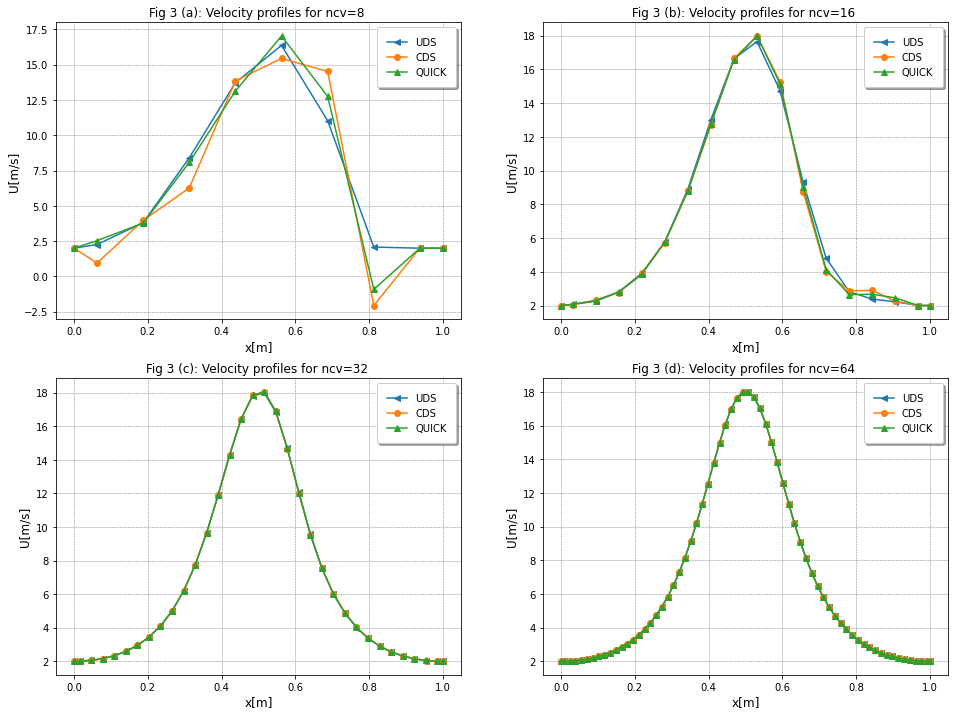

In [436]:
""" Velocity Plot for Comparison of 3 Schemes """
%matplotlib inline

import matplotlib.pyplot as plt

fig = plt.figure(figsize =(16,12))
axes1 = fig.add_subplot(2,2,3)
axes2 = fig.add_subplot(2,2,4)
axes3 = fig.add_subplot(2,2,1)
axes4 = fig.add_subplot(2,2,2)

axes1.plot(loc_uds_32, U_uds_32 , marker = "<", label = "UDS")
axes1.plot(loc_cds_32, U_cds_32 , marker = "o", label = "CDS")
axes1.plot(loc_quick_32, U_quick_32, marker = "^", label = "QUICK")
axes1.set_xlabel('x[m]',fontsize = 12)
axes1.set_ylabel('U[m/s]',fontsize = 12)
axes1.set_title('Fig 3 (c): Velocity profiles for ncv=32 ',fontsize = 12)
axes1.grid(True)
axes1.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
axes1.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)

axes2.plot(loc_uds_64, U_uds_64 , marker = "<", label = "UDS")
axes2.plot(loc_cds_64, U_cds_64 , marker = "o", label = "CDS")
axes2.plot(loc_quick_64, U_quick_64, marker = "^", label = "QUICK")
axes2.set_xlabel('x[m]',fontsize = 12)
axes2.set_ylabel('U[m/s]',fontsize = 12)
axes2.set_title('Fig 3 (d): Velocity profiles for ncv=64 ',fontsize = 12)
axes2.grid(True)
axes2.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
axes2.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)

axes3.plot(loc_uds_8, U_uds_8 , marker = "<", label = "UDS")
axes3.plot(loc_cds_8, U_cds_8 , marker = "o", label = "CDS")
axes3.plot(loc_quick_8, U_quick_8 , marker = "^", label = "QUICK")
axes3.set_xlabel('x[m]',fontsize = 12)
axes3.set_ylabel('U[m/s]',fontsize = 12)
axes3.set_title('Fig 3 (a): Velocity profiles for ncv=8 ',fontsize = 12)
axes3.grid(True)
axes3.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
axes3.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)

axes4.plot(loc_uds_16, U_uds_16 , marker = "<", label = "UDS")
axes4.plot(loc_cds_16, U_cds_16 , marker = "o", label = "CDS")
axes4.plot(loc_quick_16, U_quick_16 , marker = "^", label = "QUICK")
axes4.set_xlabel('x[m]',fontsize = 12)
axes4.set_ylabel('U[m/s]',fontsize = 12)
axes4.set_title('Fig 3 (b): Velocity profiles for ncv=16 ',fontsize = 12)
axes4.grid(True)
axes4.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
axes4.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)

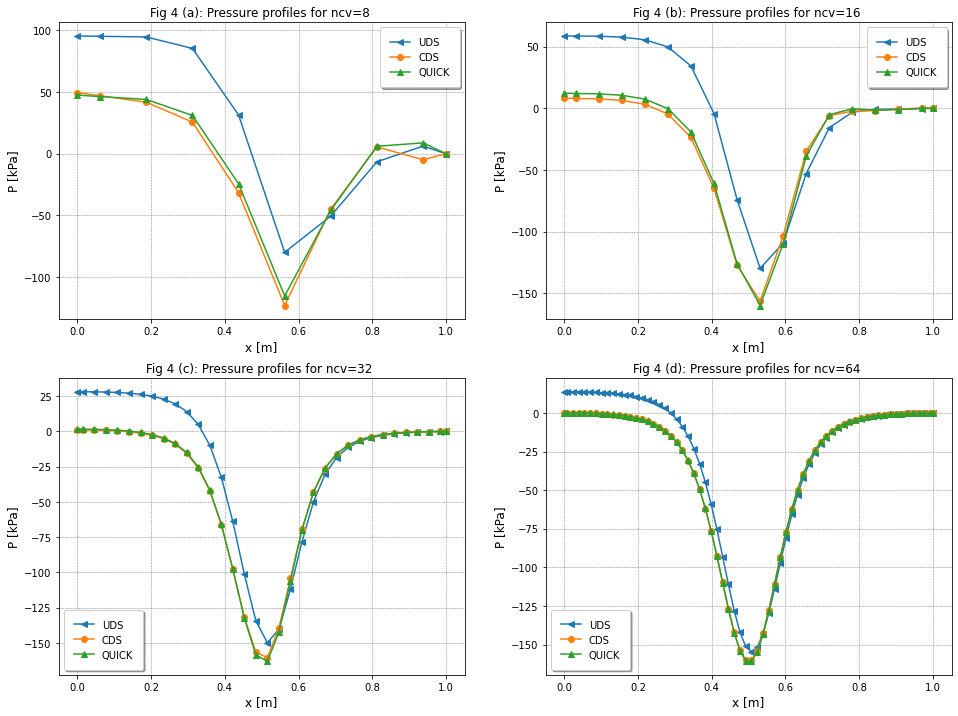

In [437]:
""" Pressure Plot for Comparison of 3 Schemes """
%matplotlib inline

import matplotlib.pyplot as plt

fig = plt.figure(figsize =(16,12))
axes1 = fig.add_subplot(2,2,3)
axes2 = fig.add_subplot(2,2,4)
axes3 = fig.add_subplot(2,2,1)
axes4 = fig.add_subplot(2,2,2)

axes1.plot(loc_uds_32, P_uds_32/1000 , marker = "<", label = "UDS")
axes1.plot(loc_cds_32, P_cds_32/1000 , marker = "o", label = "CDS")
axes1.plot(loc_quick_32, P_quick_32/1000, marker = "^", label = "QUICK")
axes1.set_xlabel('x [m]',fontsize = 12)
axes1.set_ylabel('P [kPa]',fontsize = 12)
axes1.set_title('Fig 4 (c): Pressure profiles for ncv=32 ',fontsize = 12)
axes1.grid(True)
axes1.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
axes1.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)

axes2.plot(loc_uds_64, P_uds_64/1000 , marker = "<", label = "UDS")
axes2.plot(loc_cds_64, P_cds_64/1000 , marker = "o", label = "CDS")
axes2.plot(loc_quick_64, P_quick_64/1000, marker = "^", label = "QUICK")
axes2.set_xlabel('x [m]',fontsize = 12)
axes2.set_ylabel('P [kPa]',fontsize = 12)
axes2.set_title('Fig 4 (d): Pressure profiles for ncv=64 ',fontsize = 12)
axes2.grid(True)
axes2.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
axes2.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)

axes3.plot(loc_uds_8, P_uds_8/1000 , marker = "<", label = "UDS")
axes3.plot(loc_cds_8, P_cds_8/1000 , marker = "o", label = "CDS")
axes3.plot(loc_quick_8, P_quick_8/1000 , marker = "^", label = "QUICK")
axes3.set_xlabel('x [m]',fontsize = 12)
axes3.set_ylabel('P [kPa]',fontsize = 12)
axes3.set_title('Fig 4 (a): Pressure profiles for ncv=8 ',fontsize = 12)
axes3.grid(True)
axes3.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
axes3.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)

axes4.plot(loc_uds_16, P_uds_16/1000 , marker = "<", label = "UDS")
axes4.plot(loc_cds_16, P_cds_16/1000 , marker = "o", label = "CDS")
axes4.plot(loc_quick_16, P_quick_16/1000 , marker = "^", label = "QUICK")
axes4.set_xlabel('x [m]',fontsize = 12)
axes4.set_ylabel('P [kPa]',fontsize = 12)
axes4.set_title('Fig 4 (b): Pressure profiles for ncv=16 ',fontsize = 12)
axes4.grid(True)
axes4.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
axes4.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)

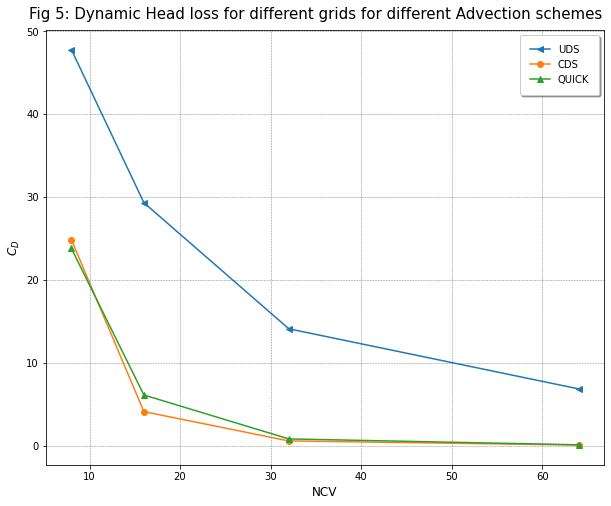

In [439]:
 """Plot of dynamic head loss for 3 schemes for different # of control volumes """

ncv = np.array([8,16,32,64])
denom = (1/2)*1000*(2**2)
UDS_num = np.array([P_uds_8[0]-P_uds_8[-1],P_uds_16[0]-P_uds_16[-1],P_uds_32[0]-P_uds_32[-1],P_uds_64[0]-P_uds_64[-1]])
CDS_num = np.array([P_cds_8[0]-P_cds_8[-1],P_cds_16[0]-P_cds_16[-1],P_cds_32[0]-P_cds_32[-1],P_cds_64[0]-P_cds_64[-1]])
QUICK_num = np.array([P_quick_8[0]-P_quick_8[-1],P_quick_16[0]-P_quick_16[-1],P_quick_32[0]-P_quick_32[-1],P_quick_64[0]-P_quick_64[-1]])
Cd_UDS = UDS_num/denom
Cd_CDS = CDS_num/denom
Cd_QUICK = QUICK_num/denom

%matplotlib inline

import matplotlib.pyplot as plt

plt.figure(figsize =(10,8))

plt.plot(ncv, Cd_UDS , marker = "<", label = "UDS")
plt.plot(ncv, Cd_CDS, marker = "o", label = "CDS")
plt.plot(ncv, Cd_QUICK , marker = "^", label = "QUICK")
plt.xlabel('NCV', fontsize = 12)
plt.ylabel('$C_D$', fontsize =12)
plt.suptitle('Fig 5: Dynamic Head loss for different grids for different Advection schemes', fontsize=15,y=0.92)
plt.grid(True)
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.show()

# Comments on the results

The dynamic head loss calculated for each advection scheme, when the domain is discretized into different number of control volumes is tabulated as below:

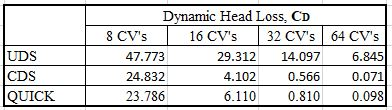



At first let us figure out what $should$ $be$ the value of $C_D$ for this problem. We can use the Bernoulli's equation to find out the inlet pressure, knowing that the inlet & outlet velocities are both 2 m/s from the velocity plot,the outlet pressure given 0 and inlet-outlet are at same elevation. Thus, $P_{in}$ = 0. Plugging these values in the formula for dynamic head loss:
$$
    C_D= \frac{P_{in} - P_{out}}{\frac{1}{2} \rho U_{in}^2}
$$
We get, $C_{D(theoretical)}$ = 0

Now from the above tabulated values, we observe that, as ncv increases the value of $C_D$ decreases; For CDS and QUICK advection schemes for ncv = 64, $C_D$ = 0.071 & 0.098 respectively. Whereas for UDS scheme, it is 6.845. So it is obvious that CDS and QUICK are more accurate, as the $C_D$ values are closer to the theoretical value.

Now looking at the Velocity plots in Fig. 3, we notice that for ncv = 8 CDS shows some osciallations in the final velocity, but for higher ncv (16,32 & 64) all three schemes show smoother velocity profile with 2m/s at inlet and outlet. The Pressure plots in Fig. 4 reveal that as ncv increases, CDS and QUICK schemes close in on $P_{in}$ = 0, however UDS even at ncv=64, shows large deviation of the inlet pressure from the theoretical value. As such, the dynamic head loss calculated for CDS and QUICK schemes for ncv = 64 are closer to the theoretical value, whereas UDS is quite high.


Compare your solutions from UDS with those from the second-order schemes and quantify the convergence characteristics of each.  Plot the velocities and pressures versus $x$ for enough of the cases to visualize the results properly.  What should $C_D$ become for this problem?